## 1. Preparation and Pre-Processing

### 1.1 Import Time-Series Dataset

In [2]:
import pandas as pd

# Load wrangled dataset from the processed folder
final_df = pd.read_parquet("data/processed/final_demand.parquet")

# Quick check
print(final_df.shape)
final_df.head()

(103, 5)


,California 1 (ID:46673),California 2 (ID:4904),New York 1 (ID:12631),New York 2 (ID:20974),total
ts_date,,,,,
2015-03-05,152,0.0,232,0.0,384.0
2015-03-06,100,0.0,227,4.0,331.0
2015-03-07,54,0.0,181,0.0,235.0
2015-03-08,199,0.0,221,0.0,420.0
2015-03-09,166,0.0,229,0.0,395.0


In [4]:
y_46673 = final_df.iloc[:,0]
y_4904 = final_df.iloc[:,1]
y_12631 = final_df.iloc[:,2]
y_20974 = final_df.iloc[:,3]

In [6]:
time_series_dict = {
    'y_46673': y_46673,
    'y_4904': y_4904,
    'y_12631': y_12631,
    'y_20974': y_20974
}

### 1.2 Plotting the Time Series

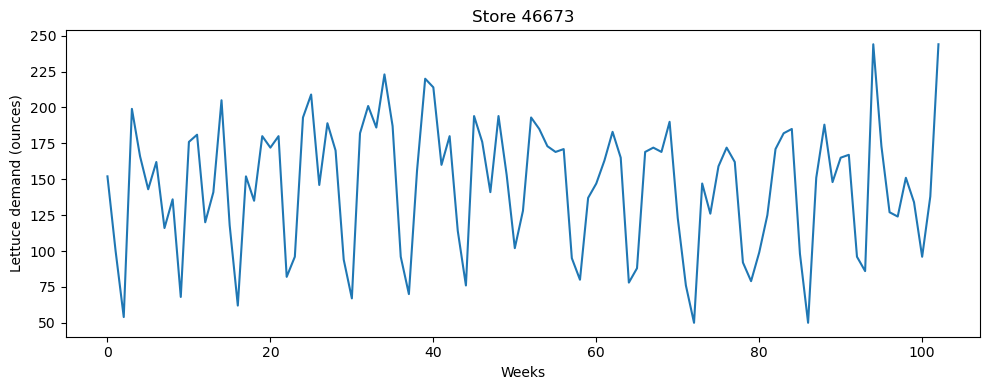

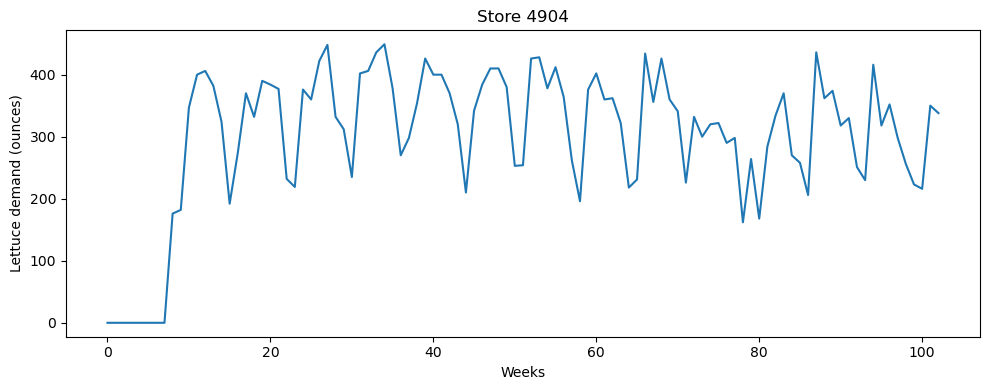

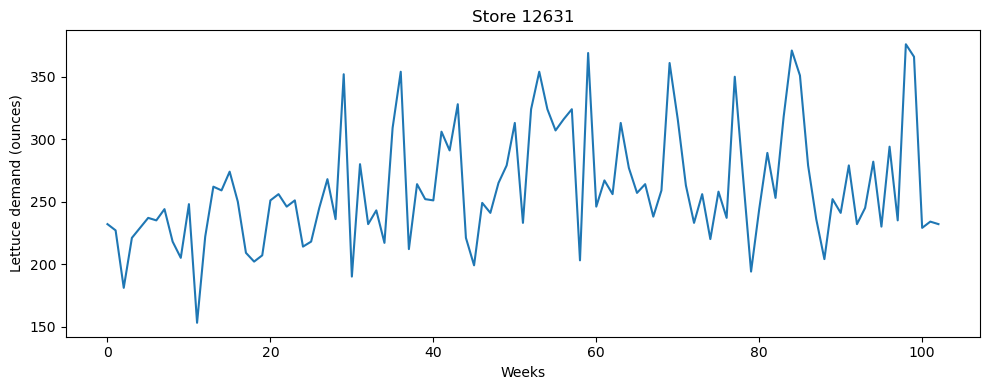

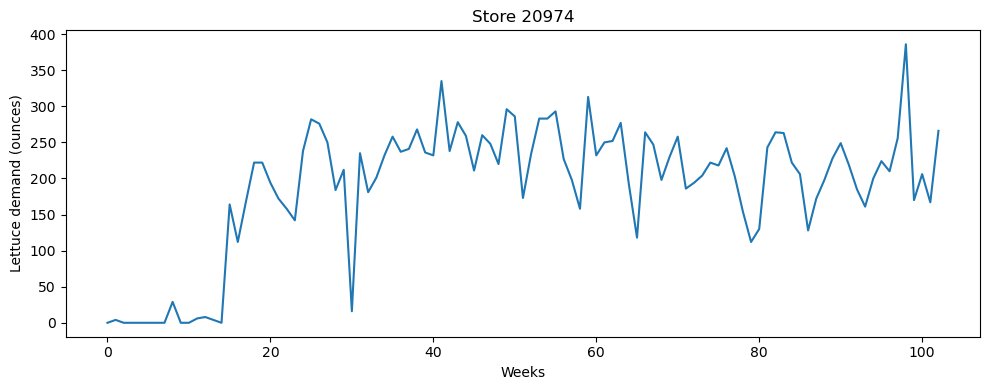

In [8]:
import matplotlib.pyplot as plt
import re

for name, series in time_series_dict.items():
    match = re.search(r'y_(\d+)', name)
    store_number = match.group(1) if match else "aggregate"
    
    # Use a numeric x-axis: 0 to len(series) - 1
    weeks = range(len(series))
    
    plt.figure(figsize=(10, 4))
    plt.plot(weeks, series.values)  # x = week numbers, y = demand
    plt.xlabel("Weeks")
    plt.ylabel("Lettuce demand (ounces)")
    plt.title(f"Store {store_number}")
    plt.tight_layout()
    plt.show()

### 1.3 Adjustment of beginning period

Since Store 4904 does not have any demand at the very beginning and Store 20974 a very low one, the time-series for those two stores are initiated later to not distort any of the trends.

#### 1.3.1 Store 4904

In [10]:
y_4904.head(20)

ts_date
2015-03-05      0.0
2015-03-06      0.0
2015-03-07      0.0
2015-03-08      0.0
2015-03-09      0.0
2015-03-10      0.0
2015-03-11      0.0
2015-03-12      0.0
2015-03-13    176.0
2015-03-14    182.0
2015-03-15    347.0
2015-03-16    400.0
2015-03-17    406.0
2015-03-18    382.0
2015-03-19    324.0
2015-03-20    192.0
2015-03-21    274.0
2015-03-22    370.0
2015-03-23    332.0
2015-03-24    390.0
Name: California 2 (ID:4904), dtype: float64

Store 4904 will be initiated from position 8

In [12]:
y_4904 = final_df.iloc[8:, 1]
y_4904

ts_date
2015-03-13    176.0
2015-03-14    182.0
2015-03-15    347.0
2015-03-16    400.0
2015-03-17    406.0
              ...  
2015-06-11    256.0
2015-06-12    223.0
2015-06-13    216.0
2015-06-14    350.0
2015-06-15    338.0
Name: California 2 (ID:4904), Length: 95, dtype: float64

#### 1.3.2 Store 20974

In [14]:
y_20974.head(20)

ts_date
2015-03-05      0.0
2015-03-06      4.0
2015-03-07      0.0
2015-03-08      0.0
2015-03-09      0.0
2015-03-10      0.0
2015-03-11      0.0
2015-03-12      0.0
2015-03-13     29.0
2015-03-14      0.0
2015-03-15      0.0
2015-03-16      6.0
2015-03-17      8.0
2015-03-18      4.0
2015-03-19      0.0
2015-03-20    164.0
2015-03-21    112.0
2015-03-22    168.0
2015-03-23    222.0
2015-03-24    222.0
Name: New York 2 (ID:20974), dtype: float64

Store 20974 will be initiated from position 15

In [16]:
y_20974 = final_df.iloc[15:, 3]
y_20974

ts_date
2015-03-20    164.0
2015-03-21    112.0
2015-03-22    168.0
2015-03-23    222.0
2015-03-24    222.0
              ...  
2015-06-11    386.0
2015-06-12    170.0
2015-06-13    206.0
2015-06-14    167.0
2015-06-15    266.0
Name: New York 2 (ID:20974), Length: 88, dtype: float64

In [18]:
#Reinitiate to store updated ts

time_series_dict = {
    'y_46673': y_46673,
    'y_4904': y_4904,
    'y_12631': y_12631,
    'y_20974': y_20974
}

### 1.4 Train-Test Split

We are dealing witha 14-days forecasting horizon. As the datasets are relatively small, at this point it is aimed to not lose model precision by designing training-data as insufficiently small. Hence the test set will be aligned with the length of the target window.

In [20]:
# Number of test points
test_size = 14

for name, series in time_series_dict.items():
    train = series[:-test_size]
    test = series[-test_size:]
    
    # Dynamically assign the new variables
    globals()[f"{name}_train"] = train
    globals()[f"{name}_test"] = test

    # Print lengths for verification
    print(f"{name}_train: {len(train)} points, {name}_test: {len(test)} points")

y_46673_train: 89 points, y_46673_test: 14 points
y_4904_train: 81 points, y_4904_test: 14 points
y_12631_train: 89 points, y_12631_test: 14 points
y_20974_train: 74 points, y_20974_test: 14 points


## 2. Holt-Winters Model

### 2.1 Store 46673

In [22]:
y = y_46673_train.copy()

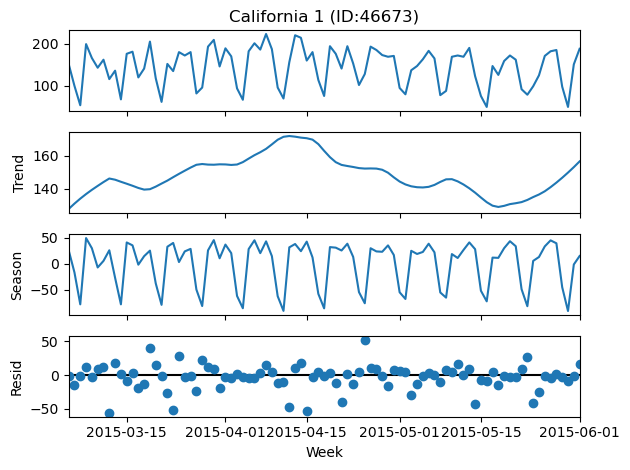

Component importance (IQR as % of observed IQR):

Trend      importance: 17.80%
Seasonal   importance: 97.83%
Remainder  importance: 22.93%


In [24]:
from statsmodels.tsa.seasonal import STL

# Ensure y has a proper datetime index and frequency
y.index.freq = 'D'  # Or 'W' if it's weekly

# Perform STL decomposition
stl = STL(y, seasonal=7, robust=True)
result = stl.fit()

# Plot decomposition
fig = result.plot()
plt.xlabel('Week')
plt.tight_layout()
plt.show()

# Compute observed IQR once
observed_iqr = result.observed.quantile(0.75) - result.observed.quantile(0.25)

print("Component importance (IQR as % of observed IQR):\n")
for name, values in {
    'trend': result.trend,
    'seasonal': result.seasonal,
    'remainder': result.resid
}.items():
    iqr = values.quantile(0.75) - values.quantile(0.25)
    importance_pct = (iqr / observed_iqr) * 100
    print(f"{name.capitalize():<10} importance: {importance_pct:.2f}%")

In [26]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Manual model: ANA (Additive Error, No Trend, Additive Seasonality)
y_46673_ets = ExponentialSmoothing(
    y_46673_train,
    trend=None,
    seasonal='add',
    seasonal_periods=7
).fit()

In [28]:
import itertools

# Define model config grid
error_types = ['add']
trend_types = [None, 'add']
seasonal_types = [None, 'add']
seasonal_period = 7

results = []

for trend, seasonal in itertools.product(trend_types, seasonal_types):
    try:
        model = ExponentialSmoothing(
            y_46673_train,
            trend=trend,
            seasonal=seasonal,
            seasonal_periods=seasonal_period if seasonal else None
        ).fit()
        results.append({
            'trend': trend or 'N',
            'seasonal': seasonal or 'N',
            'aic': model.aic,
            'bic': model.bic,
            'model': model
        })
    except:
        continue

In [30]:
df_results = pd.DataFrame(results)

# AIC-based selection
aic_best = df_results.loc[df_results['aic'].idxmin()]
y_46673_ets_a = aic_best['model']
print("AIC-selected components:", ['A', aic_best['trend'], aic_best['seasonal']])

# BIC-based selection
bic_best = df_results.loc[df_results['bic'].idxmin()]
y_46673_ets_b = bic_best['model']
print("BIC-selected components:", ['A', bic_best['trend'], bic_best['seasonal']])

AIC-selected components: ['A', 'N', 'add']
BIC-selected components: ['A', 'N', 'add']


In [32]:
forecast_46673 = y_46673_ets.forecast(steps=14)

In [34]:
y_true = y_46673_test[:14]  # true values
y_pred = forecast_46673     # predicted values

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape_val = smape(y_true, y_pred)
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'SMAPE': smape_val
    }

# 1. Forecast on train set
train_pred = y_46673_ets.fittedvalues
train_metrics = compute_metrics(y_46673_train, train_pred)

# 2. Forecast on test set
forecast_46673 = y_46673_ets.forecast(steps=14)
test_metrics = compute_metrics(y_46673_test[:14], forecast_46673)

# 3. Display nicely
metrics_df = pd.DataFrame([train_metrics, test_metrics], index=['Train', 'Test'])
print(metrics_df.round(2))

         MAE   RMSE   MAPE  SMAPE
Train  18.40  23.06  14.13  13.67
Test   28.21  38.36  18.27  19.68


In [38]:
# Initialize an empty list to collect data
all_metrics = []

# For each store/model combination (example loop below)
store_name = '44673'
model_name = 'Holt-Winters'
rows = ['Train', 'Test']  # or any other row subset

# Select and label the relevant metrics
selected_metrics_df = (
    metrics_df.loc[rows]
    .assign(Store=store_name, Model=model_name)
    .reset_index()
)

# Append to the list
all_metrics.append(selected_metrics_df)

In [40]:
# 1. Fit final ETS model to full series (as in R's ets_final)
y_46673_ets_final = ExponentialSmoothing(
    y_46673,
    trend=None,
    seasonal='add',
    seasonal_periods=7
).fit()

# 2. Forecast 14 steps ahead
y_46673_fc_values = y_46673_ets_final.forecast(steps=14)

# 3. Estimate residual standard deviation
resid_std = np.std(y_46673_ets_final.resid, ddof=1)

# 4. Create confidence intervals manually (normal approx)
z_80 = 1.28  # 80% CI
z_95 = 1.96  # 95% CI

y_46673_fc = pd.DataFrame({
    'Point Forecast': y_46673_fc_values,
    'Low 80': y_46673_fc_values - z_80 * resid_std,
    'High 80': y_46673_fc_values + z_80 * resid_std,
    'Low 95': y_46673_fc_values - z_95 * resid_std,
    'High 95': y_46673_fc_values + z_95 * resid_std
})

# 4. Assign forecast dates as index
y_46673_fc.index = pd.date_range(start=y_46673.index[-1] + pd.Timedelta(days=1), periods=14, freq='D')
y_46673_fc = y_46673_fc.round(2)

# Display result
y_46673_hw_fc = y_46673_fc
y_46673_hw_fc

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,Point Forecast,Low 80,High 80,Low 95,High 95
2015-06-16,162.18,129.16,195.20,111.61,212.74
2015-06-17,175.32,142.30,208.34,124.76,225.88
2015-06-18,166.68,133.66,199.70,116.12,217.24
2015-06-19,102.87,69.85,135.89,52.31,153.43
2015-06-20,78.84,45.82,111.86,28.28,129.40
2015-06-21,170.72,137.70,203.74,120.15,221.28
2015-06-22,177.45,144.43,210.47,126.89,228.01
2015-06-23,162.18,129.16,195.20,111.61,212.74
2015-06-24,175.32,142.30,208.34,124.76,225.88
2015-06-25,166.68,133.66,199.70,116.12,217.24


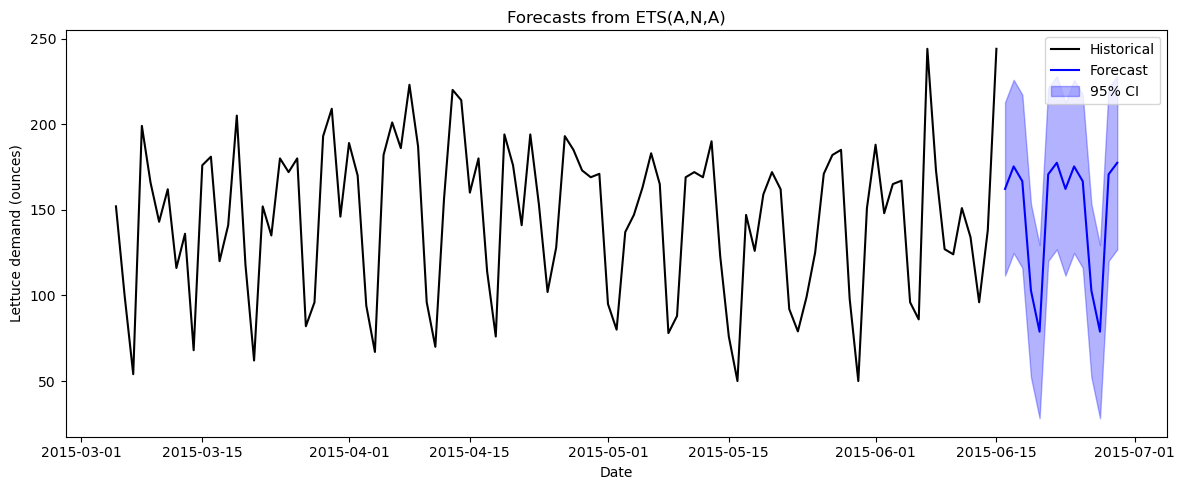

In [42]:
# 1. Plot historical data
plt.figure(figsize=(12, 5))
plt.plot(y_46673, label='Historical', color='black')

# 2. Plot point forecast
plt.plot(y_46673_fc.index, y_46673_fc['Point Forecast'], label='Forecast', color='blue')

# 3. Add shaded 80% and 95% intervals
plt.fill_between(y_46673_fc.index,
                 y_46673_fc['Low 95'],
                 y_46673_fc['High 95'],
                 color='blue', alpha=0.3, label='95% CI')

# 4. Final touches
plt.title("Forecasts from ETS(A,N,A)")
plt.xlabel("Date")
plt.ylabel("Lettuce demand (ounces)")
plt.legend()
plt.tight_layout()
plt.show()

### 2.2 Store 4904

In [44]:
y = y_4904_train.copy()

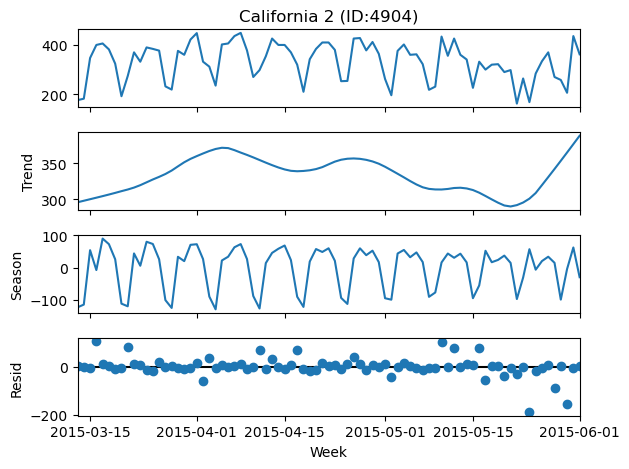

Component importance (IQR as % of observed IQR):

Trend      importance: 33.41%
Seasonal   importance: 103.55%
Remainder  importance: 15.07%


In [46]:
# Ensure y has a proper datetime index and frequency
y.index.freq = 'D'  # Or 'W' if it's weekly

# Perform STL decomposition
stl = STL(y, seasonal=7, robust=True)
result = stl.fit()

# Plot decomposition
fig = result.plot()
plt.xlabel('Week')
plt.tight_layout()
plt.show()

# Compute observed IQR once
observed_iqr = result.observed.quantile(0.75) - result.observed.quantile(0.25)

print("Component importance (IQR as % of observed IQR):\n")
for name, values in {
    'trend': result.trend,
    'seasonal': result.seasonal,
    'remainder': result.resid
}.items():
    iqr = values.quantile(0.75) - values.quantile(0.25)
    importance_pct = (iqr / observed_iqr) * 100
    print(f"{name.capitalize():<10} importance: {importance_pct:.2f}%")

Trend adds relatively few to the variation.

In [48]:
# Manual model: ANA (Additive Error, No Trend, Additive Seasonality)
y_4904_ets = ExponentialSmoothing(
    y_4904_train,
    trend=None,
    seasonal='add',
    seasonal_periods=7
).fit()

In [50]:
# Define model config grid
error_types = ['add']
trend_types = [None, 'add']
seasonal_types = [None, 'add']
seasonal_period = 7

results = []

for trend, seasonal in itertools.product(trend_types, seasonal_types):
    try:
        model = ExponentialSmoothing(
            y_4904_train,
            trend=trend,
            seasonal=seasonal,
            seasonal_periods=seasonal_period if seasonal else None
        ).fit()
        results.append({
            'trend': trend or 'N',
            'seasonal': seasonal or 'N',
            'aic': model.aic,
            'bic': model.bic,
            'model': model
        })
    except:
        continue

In [52]:
df_results = pd.DataFrame(results)

# AIC-based selection
aic_best = df_results.loc[df_results['aic'].idxmin()]
y_4904_ets_a = aic_best['model']
print("AIC-selected components:", ['A', aic_best['trend'], aic_best['seasonal']])

# BIC-based selection
bic_best = df_results.loc[df_results['bic'].idxmin()]
y_4904_ets_b = bic_best['model']
print("BIC-selected components:", ['A', bic_best['trend'], bic_best['seasonal']])

AIC-selected components: ['A', 'N', 'add']
BIC-selected components: ['A', 'N', 'add']


In [54]:
forecast_4904 = y_4904_ets.forecast(steps=14)

In [56]:
y_true = y_4904_test[:14]  # true values
y_pred = forecast_4904     # predicted values

In [58]:
# 1. Forecast on train set
train_pred = y_4904_ets.fittedvalues
train_metrics = compute_metrics(y_4904_train, train_pred)

# 2. Forecast on test set
forecast_4904 = y_4904_ets.forecast(steps=14)
test_metrics = compute_metrics(y_4904_test[:14], forecast_4904)

# 3. Display nicely
metrics_df = pd.DataFrame([train_metrics, test_metrics], index=['Train', 'Test'])
print(metrics_df.round(2))

         MAE   RMSE   MAPE  SMAPE
Train  32.06  42.98  10.93  10.51
Test   28.71  39.32   9.39   8.91


In [60]:
# For each store/model combination (example loop below)
store_name = '4904'
model_name = 'Holt-Winters'
rows = ['Train', 'Test']  # or any other row subset

# Select and label the relevant metrics
selected_metrics_df = (
    metrics_df.loc[rows]
    .assign(Store=store_name, Model=model_name)
    .reset_index()
)

# Append to the list
all_metrics.append(selected_metrics_df)

In [62]:
# 1. Fit final ETS model to full series (as in R's ets_final)
y_4904_ets_final = ExponentialSmoothing(
    y_4904,
    trend=None,
    seasonal='add',
    seasonal_periods=7
).fit()

# 2. Forecast 14 steps ahead
y_4904_fc_values = y_4904_ets_final.forecast(steps=14)

# 3. Estimate residual standard deviation
resid_std = np.std(y_4904_ets_final.resid, ddof=1)

# 4. Create confidence intervals manually (normal approx)
z_80 = 1.28  # 80% CI
z_95 = 1.96  # 95% CI

y_4904_fc = pd.DataFrame({
    'Point Forecast': y_4904_fc_values,
    'Low 80': y_4904_fc_values - z_80 * resid_std,
    'High 80': y_4904_fc_values + z_80 * resid_std,
    'Low 95': y_4904_fc_values - z_95 * resid_std,
    'High 95': y_4904_fc_values + z_95 * resid_std
})

# 4. Assign forecast dates as index
y_4904_fc.index = pd.date_range(start=y_4904.index[-1] + pd.Timedelta(days=1), periods=14, freq='D')
y_4904_fc = y_4904_fc.round(2)

# Display result
y_4904_hw_fc = y_4904_fc
y_4904_hw_fc

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,Point Forecast,Low 80,High 80,Low 95,High 95
2015-06-16,357.52,302.83,412.21,273.77,441.27
2015-06-17,347.52,292.82,402.21,263.76,431.27
2015-06-18,304.56,249.87,359.25,220.81,388.31
2015-06-19,212.85,158.15,267.54,129.10,296.60
2015-06-20,212.10,157.41,266.80,128.35,295.85
2015-06-21,337.94,283.25,392.64,254.19,421.69
2015-06-22,338.21,283.51,392.90,254.46,421.96
2015-06-23,357.52,302.83,412.21,273.77,441.27
2015-06-24,347.52,292.82,402.21,263.76,431.27
2015-06-25,304.56,249.87,359.25,220.81,388.31


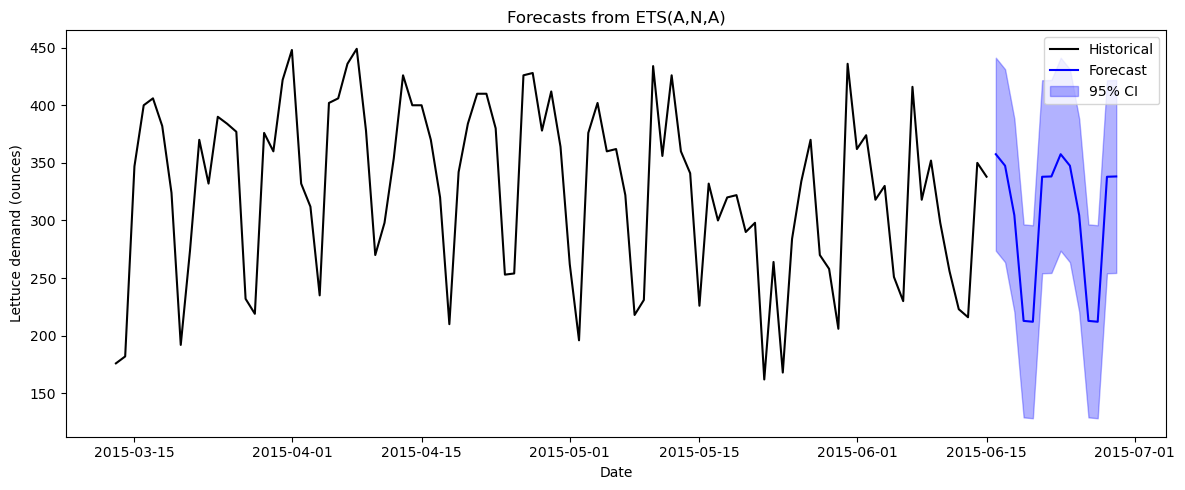

In [64]:
# 1. Plot historical data
plt.figure(figsize=(12, 5))
plt.plot(y_4904, label='Historical', color='black')

# 2. Plot point forecast
plt.plot(y_4904_fc.index, y_4904_fc['Point Forecast'], label='Forecast', color='blue')

# 3. Add shaded 80% and 95% intervals
plt.fill_between(y_4904_fc.index,
                 y_4904_fc['Low 95'],
                 y_4904_fc['High 95'],
                 color='blue', alpha=0.3, label='95% CI')

# 4. Final touches
plt.title("Forecasts from ETS(A,N,A)")
plt.xlabel("Date")
plt.ylabel("Lettuce demand (ounces)")
plt.legend()
plt.tight_layout()
plt.show()

### 2.3 Store 12631

In [66]:
y = y_12631_train.copy()

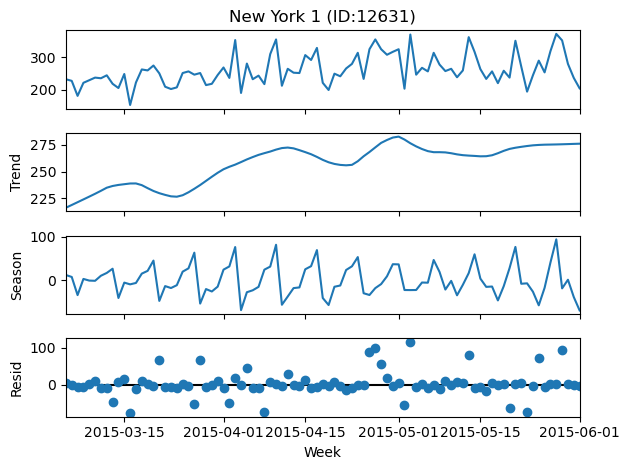

Component importance (IQR as % of observed IQR):

Trend      importance: 68.38%
Seasonal   importance: 97.56%
Remainder  importance: 28.29%


In [68]:
# Ensure y has a proper datetime index and frequency
y.index.freq = 'D'  # Or 'W' if it's weekly

# Perform STL decomposition
stl = STL(y, seasonal=7, robust=True)
result = stl.fit()

# Plot decomposition
fig = result.plot()
plt.xlabel('Week')
plt.tight_layout()
plt.show()

# Compute observed IQR once
observed_iqr = result.observed.quantile(0.75) - result.observed.quantile(0.25)

print("Component importance (IQR as % of observed IQR):\n")
for name, values in {
    'trend': result.trend,
    'seasonal': result.seasonal,
    'remainder': result.resid
}.items():
    iqr = values.quantile(0.75) - values.quantile(0.25)
    importance_pct = (iqr / observed_iqr) * 100
    print(f"{name.capitalize():<10} importance: {importance_pct:.2f}%")

Trend has higher importance compared to the other intents.

In [70]:
# Additive Trend Model
y_12631_ets_add = ExponentialSmoothing(
    y_12631_train,
    trend='add',
    seasonal=None,
    seasonal_periods=None
).fit()

# Multiplicative Trend Model
y_12631_ets_mul = ExponentialSmoothing(
    y_12631_train,
    trend='mul',
    seasonal=None,
    seasonal_periods=None
).fit()

# Forecast both for length of test set
h = len(y_12631_test)
forecast_add = y_12631_ets_add.forecast(h)
forecast_mul = y_12631_ets_mul.forecast(h)

# Calculate MAE and RMSE for comparison
from sklearn.metrics import mean_absolute_error, mean_squared_error

metrics = pd.DataFrame({
    "Model": ["Additive Trend", "Multiplicative Trend"],
    "MAE": [
        mean_absolute_error(y_12631_test, forecast_add),
        mean_absolute_error(y_12631_test, forecast_mul)
    ],
    "RMSE": [
        mean_squared_error(y_12631_test, forecast_add, squared=False),
        mean_squared_error(y_12631_test, forecast_mul, squared=False)
    ]
})

metrics

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


,Model,MAE,RMSE
0,Additive Trend,50.853837,55.951963
1,Multiplicative Trend,51.916600,56.811237


In [72]:
# Fit AAA model
y_12631_ets_aaa = ExponentialSmoothing(
    y_12631_train,
    trend='add',
    seasonal='add',
    seasonal_periods=7
).fit()

# Fit AAN model
y_12631_ets_aan = ExponentialSmoothing(
    y_12631_train,
    trend='add',
    seasonal=None
).fit()

# Forecast 14 steps ahead
aaa_forecast = y_12631_ets_aaa.forecast(14)
aan_forecast = y_12631_ets_aan.forecast(14)

# Calculate MAE and RMSE
results = pd.DataFrame({
    "Model": ["AAA", "AAN"],
    "MAE": [
        mean_absolute_error(y_12631_test, aaa_forecast),
        mean_absolute_error(y_12631_test, aan_forecast)
    ],
    "RMSE": [
        mean_squared_error(y_12631_test, aaa_forecast, squared=False),
        mean_squared_error(y_12631_test, aan_forecast, squared=False)
    ]
})

results

,Model,MAE,RMSE
0,AAA,43.863801,50.378343
1,AAN,50.853837,55.951963


In [74]:
# Define model config grid
error_types = ['add', 'mul']
trend_types = [None, 'add', 'mul']
seasonal_types = [None, 'add', 'mul']
seasonal_period = 7

results = []

# Grid search over all combinations
for error, trend, seasonal in itertools.product(error_types, trend_types, seasonal_types):
    try:
        model = ExponentialSmoothing(
            y_12631_train,
            trend=trend,
            seasonal=seasonal,
            seasonal_periods=seasonal_period if seasonal else None
        ).fit()
        results.append({
            'error': error,
            'trend': trend or 'N',
            'seasonal': seasonal or 'N',
            'aic': model.aic,
            'bic': model.bic,
            'model': model
        })
    except:
        continue

# Create a DataFrame for results
df_results = pd.DataFrame(results)

# Sort by AIC and BIC
df_sorted_aic = df_results.sort_values('aic').reset_index(drop=True)
df_sorted_bic = df_results.sort_values('bic').reset_index(drop=True)

df_results

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


,error,trend,seasonal,aic,bic,model
0,add,N,N,678.869248,683.846520,<statsmodels.tsa.holtwinters.results.HoltWinte...
1,add,N,add,655.414210,677.811937,<statsmodels.tsa.holtwinters.results.HoltWinte...
2,add,N,mul,658.031791,680.429519,<statsmodels.tsa.holtwinters.results.HoltWinte...
3,add,add,N,678.015499,687.970045,<statsmodels.tsa.holtwinters.results.HoltWinte...
4,add,add,add,656.510265,683.885265,<statsmodels.tsa.holtwinters.results.HoltWinte...
5,add,add,mul,660.261660,687.636660,<statsmodels.tsa.holtwinters.results.HoltWinte...
6,add,mul,N,678.385747,688.340292,<statsmodels.tsa.holtwinters.results.HoltWinte...
7,add,mul,add,657.494323,684.869323,<statsmodels.tsa.holtwinters.results.HoltWinte...
8,add,mul,mul,661.038923,688.413923,<statsmodels.tsa.holtwinters.results.HoltWinte...
9,mul,N,N,678.869248,683.846520,<statsmodels.tsa.holtwinters.results.HoltWinte...


In [76]:
# AIC-based selection
df_results_aic = df_results.dropna(subset=['aic'])  # drop invalid models
aic_best = df_results_aic.loc[df_results_aic['aic'].idxmin()]
y_12631_ets_a = aic_best['model']
print("AIC-selected components:", ['A', aic_best['trend'], aic_best['seasonal']])

# BIC-based selection
df_results_bic = df_results.dropna(subset=['bic'])  # drop invalid models
bic_best = df_results_bic.loc[df_results_bic['bic'].idxmin()]
y_12631_ets_b = bic_best['model']
print("BIC-selected components:", ['A', bic_best['trend'], bic_best['seasonal']])

AIC-selected components: ['A', 'N', 'add']
BIC-selected components: ['A', 'N', 'add']


In [78]:
y_12631_ets_ana = ExponentialSmoothing(
    y_12631_train,
    trend='add',
    seasonal=None,
    seasonal_periods='add'
).fit()

forecast_12631 = y_12631_ets_ana.forecast(steps=14)

In [80]:
y_true = y_12631_test[:14]  # true values
y_pred = forecast_12631     # predicted values

In [82]:
# 1. Forecast on train set
train_pred = y_12631_ets_ana.fittedvalues
train_metrics = compute_metrics(y_12631_train, train_pred)

# 2. Forecast on test set
forecast_12631 = y_12631_ets_ana.forecast(steps=14)
test_metrics = compute_metrics(y_12631_test[:14], forecast_12631)

# 3. Display nicely
metrics_df = pd.DataFrame([train_metrics, test_metrics], index=['Train', 'Test'])
print(metrics_df.round(2))

         MAE   RMSE   MAPE  SMAPE
Train  33.96  43.13  13.20  12.85
Test   50.85  55.95  19.85  18.25


In [84]:
# For each store/model combination (example loop below)
store_name = '12631'
model_name = 'Holt-Winters'
rows = ['Train', 'Test']  # or any other row subset

# Select and label the relevant metrics
selected_metrics_df = (
    metrics_df.loc[rows]
    .assign(Store=store_name, Model=model_name)
    .reset_index()
)

# Append to the list
all_metrics.append(selected_metrics_df)

In [86]:
# 1. Fit final ETS model to full series (as in R's ets_final)
y_12631_ets_final = ExponentialSmoothing(
    y_12631,
    trend=None,
    seasonal='add',
    seasonal_periods=7
).fit()

# 2. Forecast 14 steps ahead
y_12631_fc_values = y_12631_ets_final.forecast(steps=14)

# 3. Estimate residual standard deviation
resid_std = np.std(y_12631_ets_final.resid, ddof=1)

# 4. Create confidence intervals manually (normal approx)
z_80 = 1.28  # 80% CI
z_95 = 1.96  # 95% CI

y_12631_fc = pd.DataFrame({
    'Point Forecast': y_12631_fc_values,
    'Low 80': y_12631_fc_values - z_80 * resid_std,
    'High 80': y_12631_fc_values + z_80 * resid_std,
    'Low 95': y_12631_fc_values - z_95 * resid_std,
    'High 95': y_12631_fc_values + z_95 * resid_std
})

# 4. Assign forecast dates as index
y_12631_fc.index = pd.date_range(start=y_12631.index[-1] + pd.Timedelta(days=1), periods=14, freq='D')
y_12631_fc = y_12631_fc.round(2)

# Display result
y_12631_hw_fc = y_12631_fc
y_12631_hw_fc

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,Point Forecast,Low 80,High 80,Low 95,High 95
2015-06-16,263.84,216.26,311.43,190.98,336.70
2015-06-17,277.71,230.13,325.30,204.85,350.58
2015-06-18,307.66,260.08,355.24,234.80,380.52
2015-06-19,303.61,256.02,351.19,230.75,376.47
2015-06-20,235.64,188.06,283.23,162.78,308.51
2015-06-21,265.82,218.24,313.41,192.96,338.69
2015-06-22,246.36,198.78,293.95,173.50,319.23
2015-06-23,263.84,216.26,311.43,190.98,336.70
2015-06-24,277.71,230.13,325.30,204.85,350.58
2015-06-25,307.66,260.08,355.24,234.80,380.52


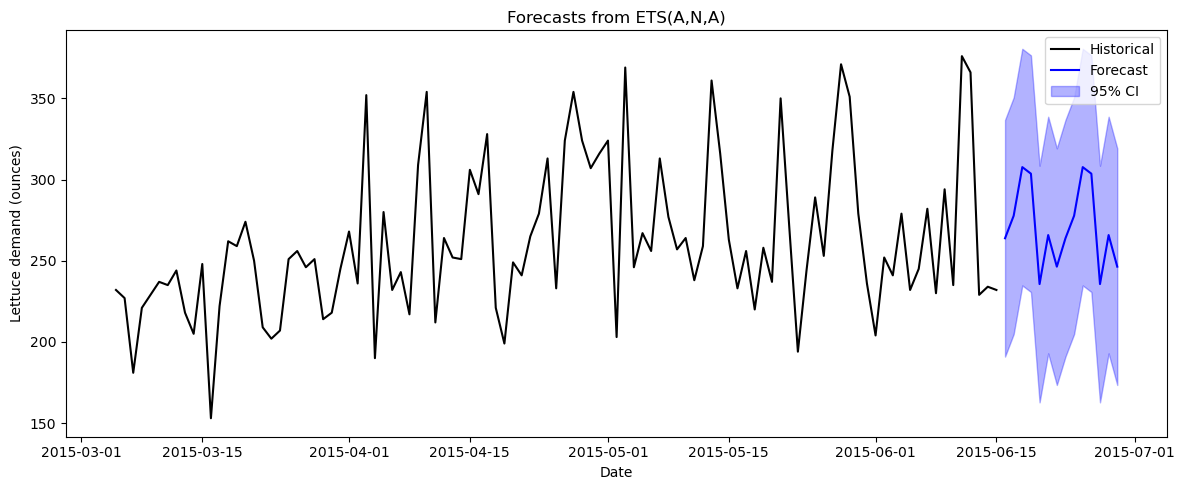

In [88]:
# 1. Plot historical data
plt.figure(figsize=(12, 5))
plt.plot(y_12631, label='Historical', color='black')

# 2. Plot point forecast
plt.plot(y_12631_fc.index, y_12631_fc['Point Forecast'], label='Forecast', color='blue')

# 3. Add shaded 80% and 95% intervals
plt.fill_between(y_12631_fc.index,
                 y_12631_fc['Low 95'],
                 y_12631_fc['High 95'],
                 color='blue', alpha=0.3, label='95% CI')

# 4. Final touches
plt.title("Forecasts from ETS(A,N,A)")
plt.xlabel("Date")
plt.ylabel("Lettuce demand (ounces)")
plt.legend()
plt.tight_layout()
plt.show()

### 2.4 Store 20974

In [90]:
y = y_20974_train.copy()

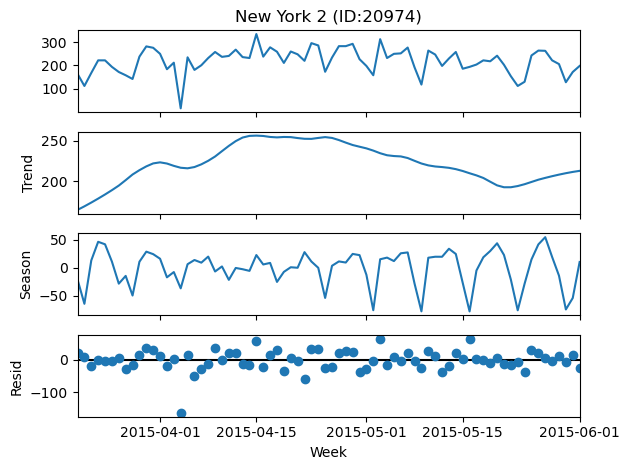

Component importance (IQR as % of observed IQR):

Trend      importance: 57.31%
Seasonal   importance: 56.29%
Remainder  importance: 57.90%


In [92]:
# Ensure y has a proper datetime index and frequency
y.index.freq = 'D'  # Or 'W' if it's weekly

# Perform STL decomposition
stl = STL(y, seasonal=7, robust=True)
result = stl.fit()

# Plot decomposition
fig = result.plot()
plt.xlabel('Week')
plt.tight_layout()
plt.show()

# Compute observed IQR once
observed_iqr = result.observed.quantile(0.75) - result.observed.quantile(0.25)

print("Component importance (IQR as % of observed IQR):\n")
for name, values in {
    'trend': result.trend,
    'seasonal': result.seasonal,
    'remainder': result.resid
}.items():
    iqr = values.quantile(0.75) - values.quantile(0.25)
    importance_pct = (iqr / observed_iqr) * 100
    print(f"{name.capitalize():<10} importance: {importance_pct:.2f}%")

Trend adds relatively few to the variation.

In [94]:
# Manual model: ANA (Additive Error, No Trend, Additive Seasonality)
y_20974_ets = ExponentialSmoothing(
    y_20974_train,
    trend=None,
    seasonal='add',
    seasonal_periods=7
).fit()

In [96]:
# Define model config grid
error_types = ['add']
trend_types = [None, 'add']
seasonal_types = [None, 'add']
seasonal_period = 7

results = []

for trend, seasonal in itertools.product(trend_types, seasonal_types):
    try:
        model = ExponentialSmoothing(
            y_20974_train,
            trend=trend,
            seasonal=seasonal,
            seasonal_periods=seasonal_period if seasonal else None
        ).fit()
        results.append({
            'trend': trend or 'N',
            'seasonal': seasonal or 'N',
            'aic': model.aic,
            'bic': model.bic,
            'model': model
        })
    except:
        continue

In [98]:
df_results = pd.DataFrame(results)

# AIC-based selection
aic_best = df_results.loc[df_results['aic'].idxmin()]
y_20974_ets_a = aic_best['model']
print("AIC-selected components:", ['A', aic_best['trend'], aic_best['seasonal']])

# BIC-based selection
bic_best = df_results.loc[df_results['bic'].idxmin()]
y_20974_ets_b = bic_best['model']
print("BIC-selected components:", ['A', bic_best['trend'], bic_best['seasonal']])

AIC-selected components: ['A', 'N', 'add']
BIC-selected components: ['A', 'N', 'add']


In [100]:
forecast_20974 = y_20974_ets.forecast(steps=14)

In [102]:
y_true = y_20974_test[:14]  # true values
y_pred = forecast_20974     # predicted values

In [104]:
# 1. Forecast on train set
train_pred = y_20974_ets.fittedvalues
train_metrics = compute_metrics(y_20974_train, train_pred)

# 2. Forecast on test set
forecast_20974 = y_20974_ets.forecast(steps=14)
test_metrics = compute_metrics(y_20974_test[:14], forecast_20974)

# 3. Display nicely
metrics_df = pd.DataFrame([train_metrics, test_metrics], index=['Train', 'Test'])
print(metrics_df.round(2))

         MAE   RMSE   MAPE  SMAPE
Train  32.98  40.38  25.25  16.64
Test   34.35  56.49  13.64  15.55


In [106]:
# For each store/model combination (example loop below)
store_name = '20974'
model_name = 'Holt-Winters'
rows = ['Train', 'Test']  # or any other row subset

# Select and label the relevant metrics
selected_metrics_df = (
    metrics_df.loc[rows]
    .assign(Store=store_name, Model=model_name)
    .reset_index()
)

# Append to the list
all_metrics.append(selected_metrics_df)

In [108]:
# 1. Fit final ETS model to full series (as in R's ets_final)
y_20974_ets_final = ExponentialSmoothing(
    y_20974,
    trend=None,
    seasonal='add',
    seasonal_periods=7
).fit()

# 2. Forecast 14 steps ahead
y_20974_fc_values = y_20974_ets_final.forecast(steps=14)

# 3. Estimate residual standard deviation
resid_std = np.std(y_20974_ets_final.resid, ddof=1)

# 4. Create confidence intervals manually (normal approx)
z_80 = 1.28  # 80% CI
z_95 = 1.96  # 95% CI

y_20974_fc = pd.DataFrame({
    'Point Forecast': y_20974_fc_values,
    'Low 80': y_20974_fc_values - z_80 * resid_std,
    'High 80': y_20974_fc_values + z_80 * resid_std,
    'Low 95': y_20974_fc_values - z_95 * resid_std,
    'High 95': y_20974_fc_values + z_95 * resid_std
})

# 4. Assign forecast dates as index
y_20974_fc.index = pd.date_range(start=y_20974.index[-1] + pd.Timedelta(days=1), periods=14, freq='D')
y_20974_fc = y_20974_fc.round(2)

# Display result
y_20974_hw_fc = y_20974_fc
y_20974_hw_fc

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,Point Forecast,Low 80,High 80,Low 95,High 95
2015-06-16,243.61,188.91,298.31,159.85,327.36
2015-06-17,258.86,204.16,313.56,175.10,342.62
2015-06-18,252.30,197.60,307.00,168.55,336.06
2015-06-19,210.85,156.15,265.55,127.10,294.61
2015-06-20,163.84,109.14,218.54,80.08,247.60
2015-06-21,223.55,168.85,278.24,139.79,307.30
2015-06-22,245.56,190.86,300.26,161.81,329.32
2015-06-23,243.61,188.91,298.31,159.85,327.36
2015-06-24,258.86,204.16,313.56,175.10,342.62
2015-06-25,252.30,197.60,307.00,168.55,336.06


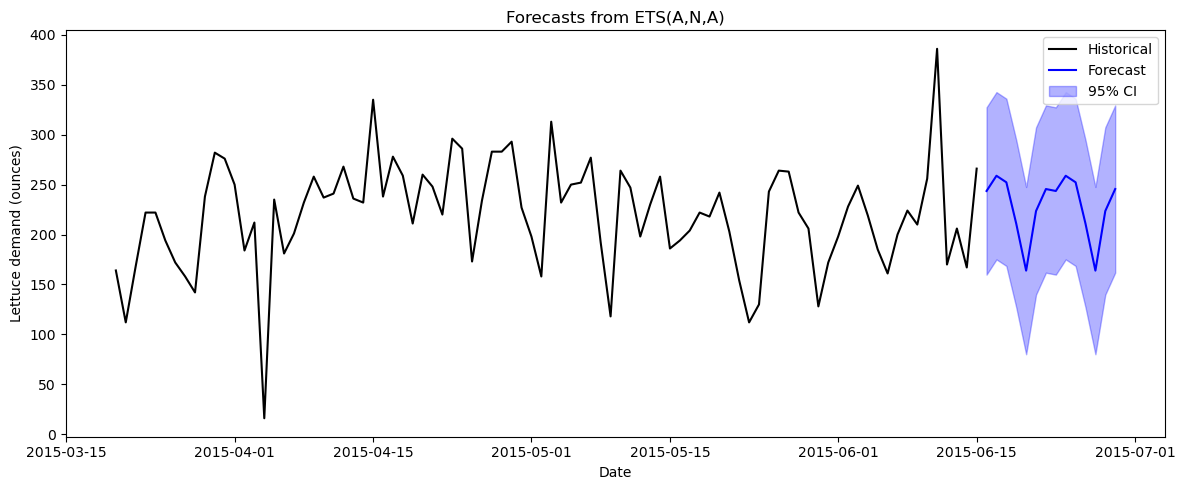

In [110]:
# 1. Plot historical data
plt.figure(figsize=(12, 5))
plt.plot(y_20974, label='Historical', color='black')

# 2. Plot point forecast
plt.plot(y_20974_fc.index, y_20974_fc['Point Forecast'], label='Forecast', color='blue')

# 3. Add shaded 80% and 95% intervals
plt.fill_between(y_20974_fc.index,
                 y_20974_fc['Low 95'],
                 y_20974_fc['High 95'],
                 color='blue', alpha=0.3, label='95% CI')

# 4. Final touches
plt.title("Forecasts from ETS(A,N,A)")
plt.xlabel("Date")
plt.ylabel("Lettuce demand (ounces)")
plt.legend()
plt.tight_layout()
plt.show()

## 3. ARIMA-Models

### 3.1 Store 46673

In [112]:
y = y_46673_train.copy()

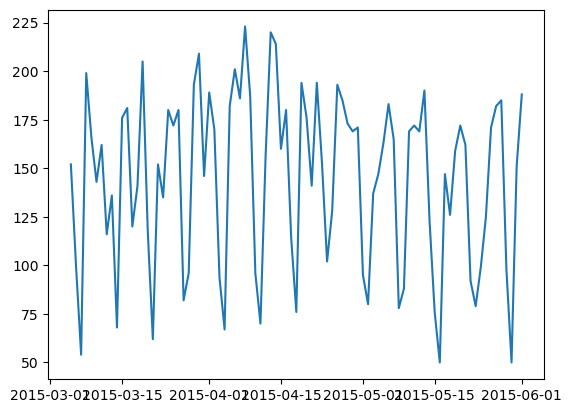

In [114]:
plt.plot(y)
plt.show()

In [116]:
from scipy.stats import kurtosis, skew

# Basic statistics
mean = np.mean(y)
std = np.std(y)
kurtosis = kurtosis(y)
skewness = skew(y)

print("Mean",mean,"Standard deviation",std,"Skewness", skewness, "Kurtosis",kurtosis)

Mean 144.7078651685393 Standard deviation 44.83031735187094 Skewness -0.4616431699927895 Kurtosis -0.8791156971926148


In [118]:
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

# Test for 0 mean
# H0: The mean of the series is equal to 0
# H1: The mean of the series is not equal to 0

t_statistic, p_value = stats.ttest_1samp(y, 0)

print(f"T-statistic: {t_statistic}")
if p_value < 0.05:
    print(f"We reject H0 that the mean is 0 with a p-value of {p_value}")
else:
    print(f"We do not reject H0 that the mean is 0 with a p-value of {p_value}")

T-statistic: 30.280403595161893
We reject H0 that the mean is 0 with a p-value of 2.5803683545404667e-48


In [120]:
# Shapiro-Wilk test for normality:

# H0: The data follows a normal distribution
# H1: The data does not follow a normal distribution
from scipy.stats import shapiro
import statsmodels.api as sm

alpha = 0.05

shapiro_test = shapiro(y)
print("Shapiro-Wilk Test for Normality")
print("Test Statistic:", shapiro_test.statistic)
print("p-value:", shapiro_test.pvalue)

# Interpret the result of the Shapiro-Wilk test
if shapiro_test.pvalue < alpha:
    print(f"We reject H0: the data does not follow a normal distribution (p-value = {shapiro_test.pvalue:.4f})")
else:
    print(f"We do not reject H0: the data follows a normal distribution (p-value = {shapiro_test.pvalue:.4f})")

Shapiro-Wilk Test for Normality
Test Statistic: 0.9442512392997742
p-value: 0.0008119454141706228
We reject H0: the data does not follow a normal distribution (p-value = 0.0008)


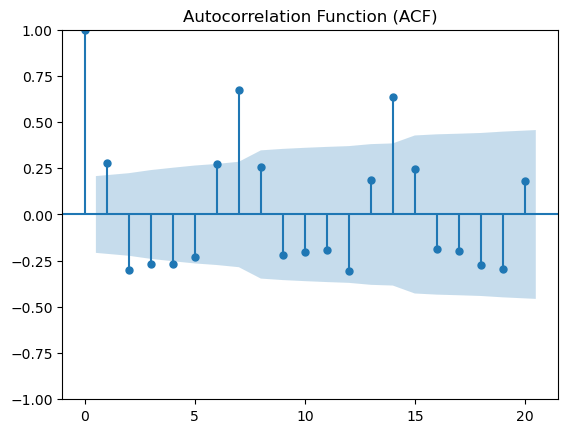

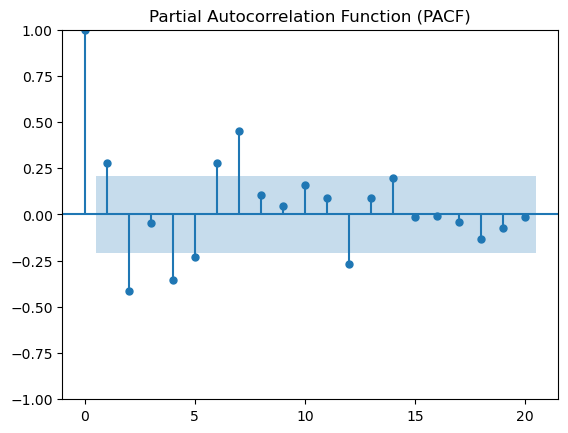

In [122]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plot_acf(y, lags=20, title="Autocorrelation Function (ACF)")
plt.show()
plot_pacf(y, lags=20, title="Partial Autocorrelation Function (PACF)")
plt.show()

We have no zero mean, rejected normal distribution and have visibly bars out of bounds. We have to test options for differencing.

In [124]:
from pmdarima.arima import nsdiffs

# Assuming weekly seasonality
D_ch = nsdiffs(y_46673_train, m=7, test='ch')
D_ocsb = nsdiffs(y_46673_train, m=7, test='ocsb')

print(f"CH Test (like R): Seasonal differences needed = {D_ch}")
print(f"OCSB Test (default): Seasonal differences needed = {D_ocsb}")

CH Test (like R): Seasonal differences needed = 0
OCSB Test (default): Seasonal differences needed = 0


The test result here is contradictory, as we see clearly recurring bars in weekly seasonality in the ACF. Seasonal differencing will be applied.

In [125]:
seasonal_period = 7
y_sdiff = y.diff(seasonal_period).dropna()

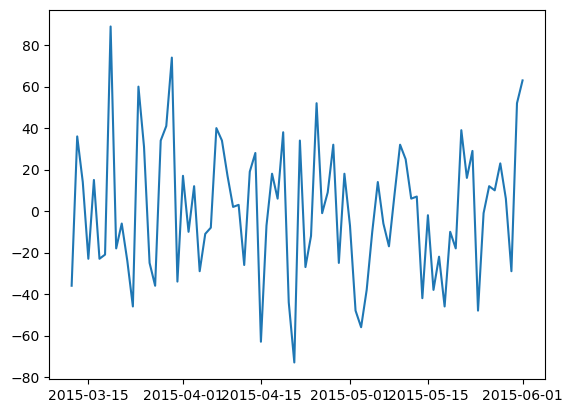

In [128]:
plt.plot(y_sdiff)
plt.show()

In [130]:
from scipy.stats import kurtosis, skew

# Basic statistics
mean = np.mean(y_sdiff)
std = np.std(y_sdiff)
kurtosis = kurtosis(y_sdiff)
skewness = skew(y_sdiff)

print("Mean",mean,"Standard deviation",std,"Skewness", skewness, "Kurtosis",kurtosis)

Mean 0.5975609756097561 Standard deviation 32.48896989414819 Skewness 0.17768165350084425 Kurtosis -0.26250967110187995


In [132]:
# Test for 0 mean
# H0: The mean of the series is equal to 0
# H1: The mean of the series is not equal to 0

t_statistic, p_value = stats.ttest_1samp(y_sdiff, 0)

print(f"T-statistic: {t_statistic}")
if p_value < 0.05:
    print(f"We reject H0 that the mean is 0 with a p-value of {p_value}")
else:
    print(f"We do not reject H0 that the mean is 0 with a p-value of {p_value}")

T-statistic: 0.1655346044522169
We do not reject H0 that the mean is 0 with a p-value of 0.8689356733884945


In [134]:
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

print("\n===> Stationarity Tests on Seasonally Differenced Series (y_sdiff) <===\n")

# ADF Test
adf_result = adfuller(y_sdiff)
print("ADF Test:")
print(f"  Test Statistic = {adf_result[0]:.4f}")
print(f"  p-value        = {adf_result[1]:.4f}")
if adf_result[1] < 0.05:
    print("  Reject H0: The series is likely stationary.\n")
else:
    print("  Fail to Reject H0: The series is likely non-stationary.\n")

# Phillips-Perron Test
pp_result = PhillipsPerron(y_sdiff)
print("Phillips-Perron (PP) Test:")
print(f"  Test Statistic = {pp_result.stat:.4f}")
print(f"  p-value        = {pp_result.pvalue:.4f}")
if pp_result.pvalue < 0.05:
    print("  Reject H0: The series is likely stationary.\n")
else:
    print("  Fail to Reject H0: The series is likely non-stationary.\n")

# KPSS Test
kpss_stat, kpss_pval, _, _ = kpss(y_sdiff, regression='c', nlags="auto")
print("KPSS Test:")
print(f"  Test Statistic = {kpss_stat:.4f}")
print(f"  p-value        = {kpss_pval:.4f}")
if kpss_pval > 0.05:
    print("  Fail to Reject H0: The series is likely stationary.\n")
else:
    print("  Reject H0: The series is likely non-stationary.\n")


===> Stationarity Tests on Seasonally Differenced Series (y_sdiff) <===

ADF Test:
  Test Statistic = -4.9444
  p-value        = 0.0000
  Reject H0: The series is likely stationary.

Phillips-Perron (PP) Test:
  Test Statistic = -8.5207
  p-value        = 0.0000
  Reject H0: The series is likely stationary.

KPSS Test:
  Test Statistic = 0.0977
  p-value        = 0.1000
  Fail to Reject H0: The series is likely stationary.



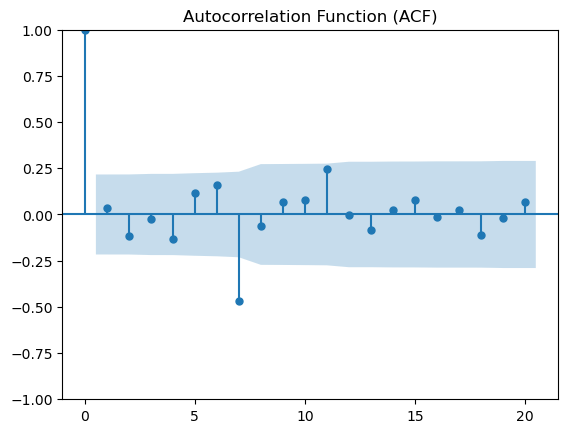

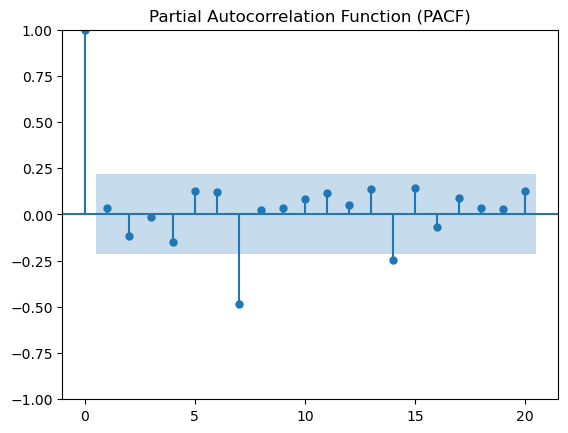

In [135]:
# Plot ACF and PACF
plot_acf(y_sdiff, lags=20, title="Autocorrelation Function (ACF)")
plt.show()
plot_pacf(y_sdiff, lags=20, title="Partial Autocorrelation Function (PACF)")
plt.show()

Clearly a bar out of bounds at 7

In [138]:
import pmdarima as pm

model_aic = pm.auto_arima(
    y,
    seasonal=True,
    m=7,           # Weekly seasonality
    D=1,           # Seasonal differencing as specified
    stepwise=False,
    n_jobs=-1,     # Use all processors
    trace=True,
    suppress_warnings=True,
    error_action='ignore',
    information_criterion='aic'
)

print(model_aic.summary())


Best model:  ARIMA(0,0,1)(0,1,1)[7] intercept
Total fit time: 9.887 seconds
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   89
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 7)   Log Likelihood                -384.532
Date:                           Tue, 26 Aug 2025   AIC                            777.064
Time:                                   17:56:52   BIC                            786.691
Sample:                               03-05-2015   HQIC                           780.929
                                    - 06-01-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.7129      1.103     -0.646  

In [139]:
model_bic = pm.auto_arima(
    y,
    seasonal=True,
    m=7,           # Weekly seasonality
    D=1,           # Seasonal differencing as specified
    stepwise=False,
    n_jobs=-1,     # Use all processors
    trace=True,
    suppress_warnings=True,
    error_action='ignore',
    information_criterion='bic'
)

print(model_bic.summary())


Best model:  ARIMA(0,0,0)(0,1,1)[7] intercept
Total fit time: 4.605 seconds
                                 SARIMAX Results                                 
Dep. Variable:                         y   No. Observations:                   89
Model:             SARIMAX(0, 1, [1], 7)   Log Likelihood                -385.903
Date:                   Tue, 26 Aug 2025   AIC                            777.805
Time:                           17:56:57   BIC                            785.025
Sample:                       03-05-2015   HQIC                           780.704
                            - 06-01-2015                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.7322      0.973     -0.753      0.452      -2.639       1.174
ma.S.L7       -0.7840      0.1

The parameters on this option are clearly significant. This is an indication that this model might do better. But we have to verify.

In [140]:
# Generate forecasts from both models
aic_train_pred = model_aic.predict_in_sample()
aic_test_forecast = model_bic.predict(n_periods=14)

bic_train_pred = model_bic.predict_in_sample()
bic_test_forecast = model_bic.predict(n_periods=14)

# Compute metrics
aic_train_metrics = compute_metrics(y_46673_train[8:], aic_train_pred[8:])
aic_test_metrics = compute_metrics(y_46673_test[:14], aic_test_forecast)

bic_train_metrics = compute_metrics(y_46673_train[8:], bic_train_pred[8:])
bic_test_metrics = compute_metrics(y_46673_test[:14], bic_test_forecast)

# Create results table
metrics_df = pd.DataFrame(
    [aic_train_metrics, aic_test_metrics, bic_train_metrics, bic_test_metrics],
    index=['AIC Train', 'AIC Test', 'BIC Train', 'BIC Test']
)

metrics_df

,MAE,RMSE,MAPE,SMAPE
AIC Train,20.208126,26.482621,14.915427,14.736516
AIC Test,30.593967,41.515654,19.601146,20.992549
BIC Train,20.415986,26.794527,15.090057,14.839751
BIC Test,30.593967,41.515654,19.601146,20.992549


In [141]:
# For each store/model combination (example loop below)
store_name = '44673'
model_name = 'Sarima'
rows = ['AIC Train', 'AIC Test']  # or any other row subset

# Select and label the relevant metrics
selected_metrics_df = (
    metrics_df.loc[rows]
    .assign(Store=store_name, Model=model_name)
    .reset_index()
)

# Append to the list
all_metrics.append(selected_metrics_df)

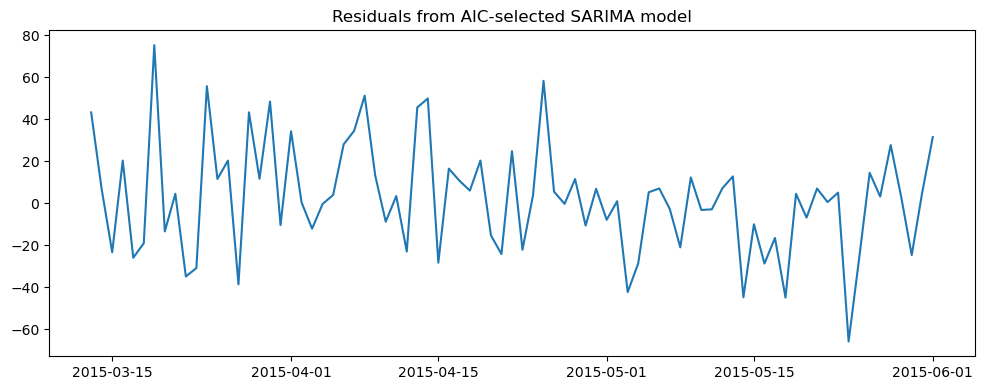

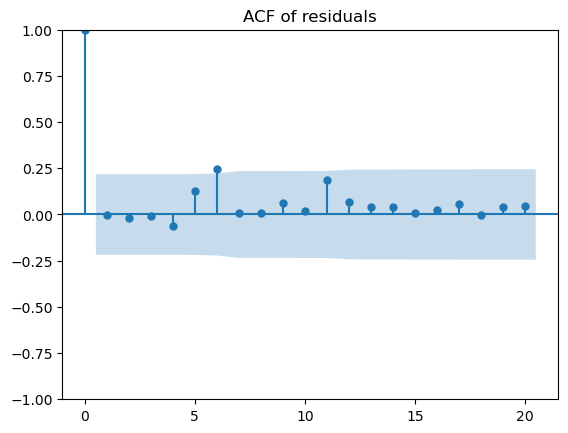

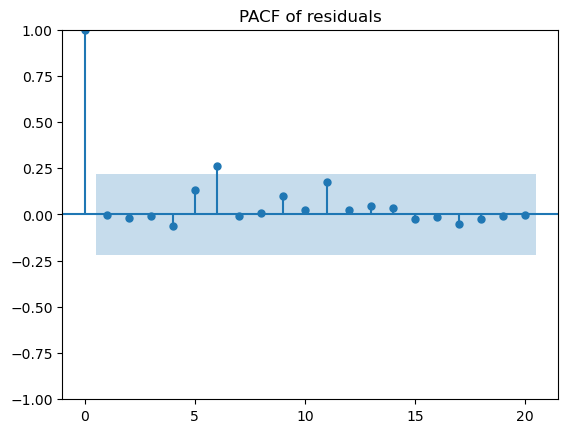


=== Ljung-Box Test for Residuals ===
Lags tested: [25]
Lag 25: p-value = 0.885 -> No significant autocorrelation
Conclusion: No significant autocorrelation detected in residuals.

=== Shapiro-Wilk Test for Normality ===
Statistic: 0.983, p-value: 0.375
Conclusion: Residuals appear to be normally distributed (fail to reject H0).


In [142]:
# Residuals from the already trained model
# Generate fitted values from the model
# Recreate residuals manually from original y
fitted = model_aic.predict_in_sample()
residuals = y - fitted
residuals = residuals.dropna()
residuals = residuals[8:]

# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title("Residuals from AIC-selected SARIMA model")
plt.tight_layout()
plt.show()

# ACF
plot_acf(residuals, lags=20)
plt.title("ACF of residuals")
plt.show()

# PACF
plot_pacf(residuals, lags=20, method="ols")
plt.title("PACF of residuals")
plt.show()

box_test = sm.stats.acorr_ljungbox(residuals, lags=[25], return_df=True)  # Using `return_df` for cleaner output

print("\n=== Ljung-Box Test for Residuals ===")
print(f"Lags tested: {box_test.index.tolist()}")
for lag, pval in zip(box_test.index, box_test['lb_pvalue']):
    print(f"Lag {lag}: p-value = {pval:.3f} -> {'No significant autocorrelation' if pval > 0.05 else 'Significant autocorrelation'}")

# Check overall result
if all(box_test['lb_pvalue'] > 0.05):
    print("Conclusion: No significant autocorrelation detected in residuals.")
else:
    print("Conclusion: Residuals show significant autocorrelation at some lags.")

# Normality test
shapiro_test = shapiro(residuals)
print("\n=== Shapiro-Wilk Test for Normality ===")
print(f"Statistic: {shapiro_test[0]:.3f}, p-value: {shapiro_test[1]:.3f}")
if shapiro_test[1] > 0.05:
    print("Conclusion: Residuals appear to be normally distributed (fail to reject H0).")
else:
    print("Conclusion: Residuals deviate from normality (reject H0).")

# Distribution visualization
mean = np.mean(residuals)
std = np.std(residuals)
mu = mean
sigma = std
x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 100)
pdf = stats.norm.pdf(x, mu, sigma)

In [148]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1. Fit SARIMA(0,0,0)(0,1,1)[7] without drift to full training series
model_46673_final = SARIMAX(
    y_46673,
    order=(0, 0, 0),
    seasonal_order=(0, 1, 1, 7),
    trend='n'
).fit()

# 2. Forecast 14 steps ahead
forecast_values = model_46673_final.forecast(steps=14)

# 3. Estimate residual standard deviation
resid_std = np.std(model_46673_final.resid, ddof=1)

# 4. Create confidence intervals manually (normal approx)
z_80 = 1.28  # 80% CI
z_95 = 1.96  # 95% CI

forecast_df = pd.DataFrame({
    'Point Forecast': forecast_values,
    'Low 80': forecast_values - z_80 * resid_std,
    'High 80': forecast_values + z_80 * resid_std,
    'Low 95': forecast_values - z_95 * resid_std,
    'High 95': forecast_values + z_95 * resid_std
})

# 5. Assign forecast dates as index
forecast_df.index = pd.date_range(start=y_46673.index[-1] + pd.Timedelta(days=1), periods=14, freq='D')
forecast_df = forecast_df.round(2)

# Display
y_46673_sarima_fc = forecast_df
y_46673_sarima_fc

,Point Forecast,Low 80,High 80,Low 95,High 95
2015-06-16,159.98,100.60,219.37,69.04,250.92
2015-06-17,173.26,113.88,232.65,82.33,264.20
2015-06-18,164.45,105.07,223.84,73.51,255.39
2015-06-19,100.73,41.34,160.12,9.79,191.67
2015-06-20,76.67,17.28,136.06,-14.27,167.61
2015-06-21,168.65,109.26,228.03,77.71,259.58
2015-06-22,176.53,117.14,235.92,85.59,267.47
2015-06-23,159.98,100.60,219.37,69.04,250.92
2015-06-24,173.26,113.88,232.65,82.33,264.20
2015-06-25,164.45,105.07,223.84,73.51,255.39


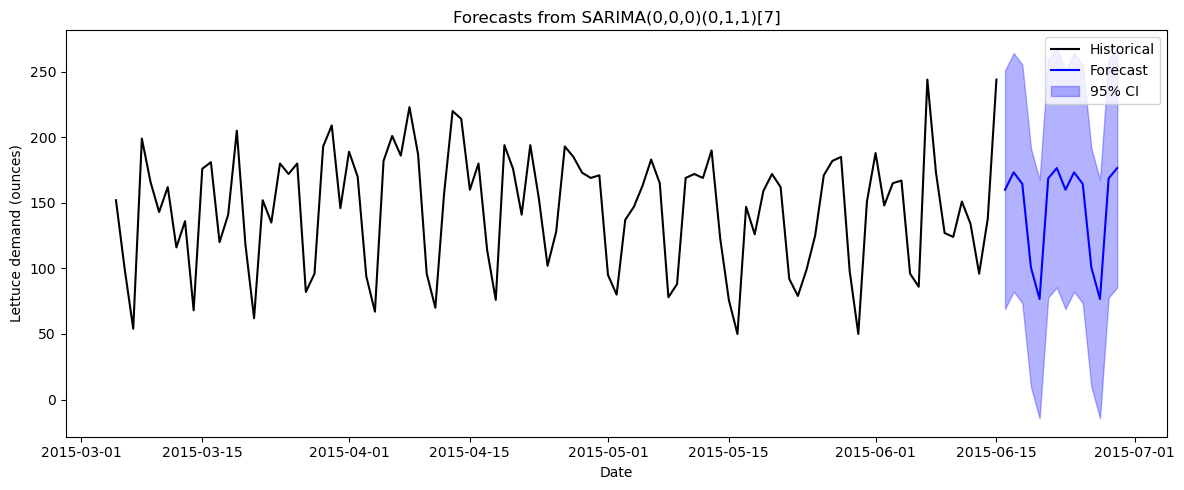

In [150]:
# 1. Plot historical data
plt.figure(figsize=(12, 5))
plt.plot(y_46673, label='Historical', color='black')

# 2. Plot point forecast
plt.plot(forecast_df.index, forecast_df['Point Forecast'], label='Forecast', color='blue')

# 3. Add shaded 80% and 95% intervals
plt.fill_between(forecast_df.index,
                 forecast_df['Low 95'],
                 forecast_df['High 95'],
                 color='blue', alpha=0.3, label='95% CI')

# 4. Final touches
plt.title("Forecasts from SARIMA(0,0,0)(0,1,1)[7]")
plt.xlabel("Date")
plt.ylabel("Lettuce demand (ounces)")
plt.legend()
plt.tight_layout()
plt.show()

### 3.2 Store 4904

In [152]:
y = y_4904_train.copy()

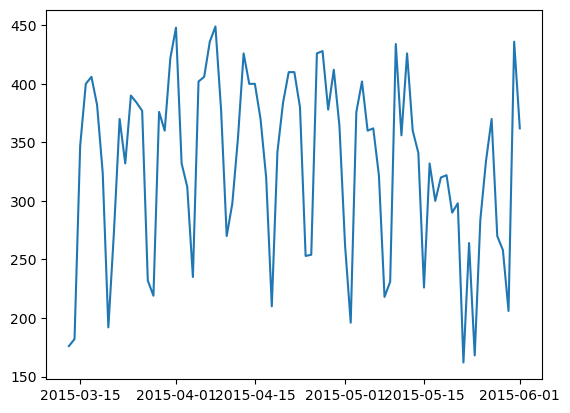

In [154]:
plt.plot(y)
plt.show()

In [156]:
from scipy.stats import kurtosis, skew

# Basic statistics
mean = np.mean(y)
std = np.std(y)
kurtosis = kurtosis(y)
skewness = skew(y)

print("Mean",mean,"Standard deviation",std,"Skewness", skewness, "Kurtosis",kurtosis)

Mean 331.85185185185185 Standard deviation 76.63527716689741 Skewness -0.5331164825539035 Kurtosis -0.7619488784266761


In [158]:
# Test for 0 mean
# H0: The mean of the series is equal to 0
# H1: The mean of the series is not equal to 0

t_statistic, p_value = stats.ttest_1samp(y, 0)

print(f"T-statistic: {t_statistic}")
if p_value < 0.05:
    print(f"We reject H0 that the mean is 0 with a p-value of {p_value}")
else:
    print(f"We do not reject H0 that the mean is 0 with a p-value of {p_value}")

T-statistic: 38.7311601983978
We reject H0 that the mean is 0 with a p-value of 1.3684350503589862e-53


In [160]:
# Shapiro-Wilk test for normality:

# H0: The data follows a normal distribution
# H1: The data does not follow a normal distribution

alpha = 0.05

shapiro_test = shapiro(y)
print("Shapiro-Wilk Test for Normality")
print("Test Statistic:", shapiro_test.statistic)
print("p-value:", shapiro_test.pvalue)

# Interpret the result of the Shapiro-Wilk test
if shapiro_test.pvalue < alpha:
    print(f"We reject H0: the data does not follow a normal distribution (p-value = {shapiro_test.pvalue:.4f})")
else:
    print(f"We do not reject H0: the data follows a normal distribution (p-value = {shapiro_test.pvalue:.4f})")

Shapiro-Wilk Test for Normality
Test Statistic: 0.9431094527244568
p-value: 0.0013094288296997547
We reject H0: the data does not follow a normal distribution (p-value = 0.0013)


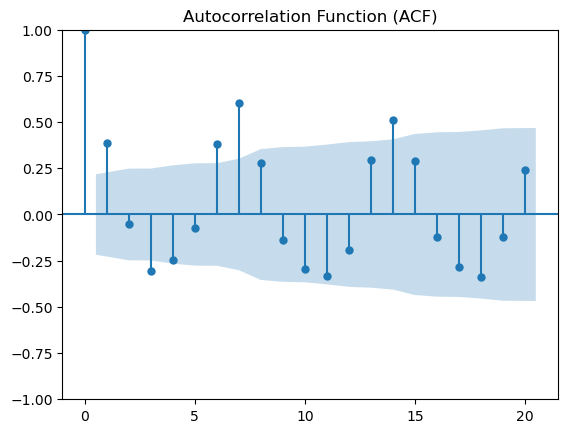

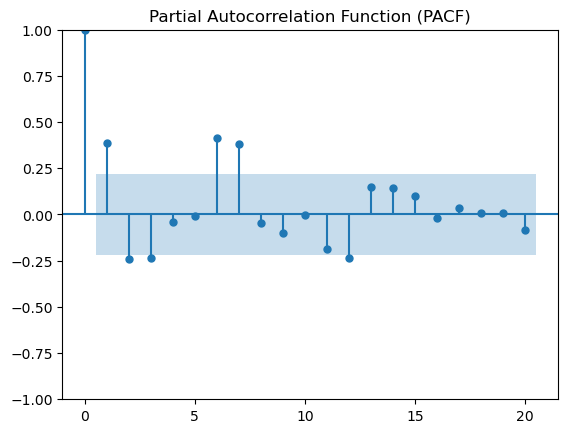

In [162]:
# Plot ACF and PACF
plot_acf(y, lags=20, title="Autocorrelation Function (ACF)")
plt.show()
plot_pacf(y, lags=20, title="Partial Autocorrelation Function (PACF)")
plt.show()

We have no zero mean, rejected normal distribution and have visibly bars out of bounds. We have to test options for differencing.

In [164]:
# Assuming weekly seasonality
D_ch = nsdiffs(y, m=7, test='ch')
D_ocsb = nsdiffs(y, m=7, test='ocsb')

print(f"CH Test (like R): Seasonal differences needed = {D_ch}")
print(f"OCSB Test (default): Seasonal differences needed = {D_ocsb}")

CH Test (like R): Seasonal differences needed = 0
OCSB Test (default): Seasonal differences needed = 0


The test result here is contradictory, as we see clearly recurring bars in weekly seasonality in the ACF. Seasonal differencing will be applied.

In [166]:
seasonal_period = 7
y_sdiff = y.diff(seasonal_period).dropna()

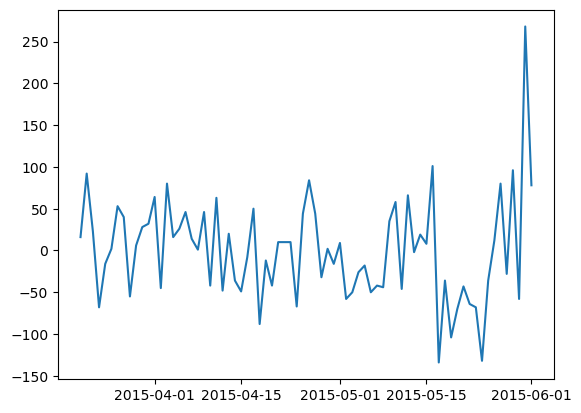

In [168]:
plt.plot(y_sdiff)
plt.show()

In [170]:
from scipy.stats import kurtosis, skew

# Basic statistics
mean = np.mean(y_sdiff)
std = np.std(y_sdiff)
kurtosis = kurtosis(y_sdiff)
skewness = skew(y_sdiff)

print("Mean",mean,"Standard deviation",std,"Skewness", skewness, "Kurtosis",kurtosis)

Mean 0.25675675675675674 Standard deviation 61.462812490245696 Skewness 0.9189695768613957 Kurtosis 3.312851290535459


In [172]:
# Test for 0 mean
# H0: The mean of the series is equal to 0
# H1: The mean of the series is not equal to 0

t_statistic, p_value = stats.ttest_1samp(y_sdiff, 0)


print(f"T-statistic: {t_statistic}")
if p_value < 0.05:
    print(f"We reject H0 that the mean is 0 with a p-value of {p_value}")
else:
    print(f"We do not reject H0 that the mean is 0 with a p-value of {p_value}")

T-statistic: 0.03569199980416552
We do not reject H0 that the mean is 0 with a p-value of 0.9716253694114307


In [174]:
# ADF Test
adf_result = adfuller(y_sdiff)
print("ADF Test:")
print(f"  Test Statistic = {adf_result[0]:.4f}")
print(f"  p-value        = {adf_result[1]:.4f}")
if adf_result[1] < 0.05:
    print("  Reject H0: The series is likely stationary.\n")
else:
    print("  Fail to Reject H0: The series is likely non-stationary.\n")

# Phillips-Perron Test
pp_result = PhillipsPerron(y_sdiff)
print("Phillips-Perron (PP) Test:")
print(f"  Test Statistic = {pp_result.stat:.4f}")
print(f"  p-value        = {pp_result.pvalue:.4f}")
if pp_result.pvalue < 0.05:
    print("  Reject H0: The series is likely stationary.\n")
else:
    print("  Fail to Reject H0: The series is likely non-stationary.\n")

# KPSS Test
kpss_stat, kpss_pval, _, _ = kpss(y_sdiff, regression='c', nlags="auto")
print("KPSS Test:")
print(f"  Test Statistic = {kpss_stat:.4f}")
print(f"  p-value        = {kpss_pval:.4f}")
if kpss_pval > 0.05:
    print("  Fail to Reject H0: The series is likely stationary.\n")
else:
    print("  Reject H0: The series is likely non-stationary.\n")

ADF Test:
  Test Statistic = -1.8485
  p-value        = 0.3567
  Fail to Reject H0: The series is likely non-stationary.

Phillips-Perron (PP) Test:
  Test Statistic = -7.8080
  p-value        = 0.0000
  Reject H0: The series is likely stationary.

KPSS Test:
  Test Statistic = 0.1550
  p-value        = 0.1000
  Fail to Reject H0: The series is likely stationary.



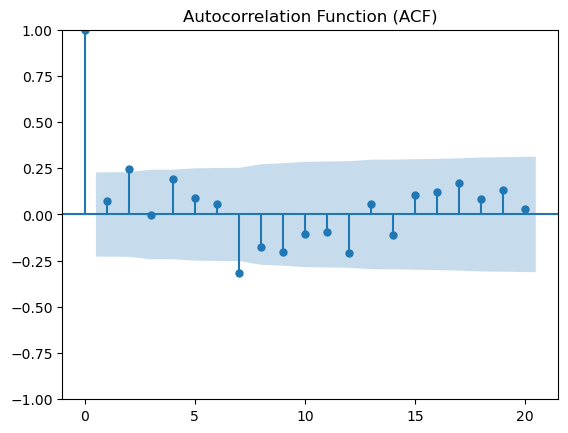

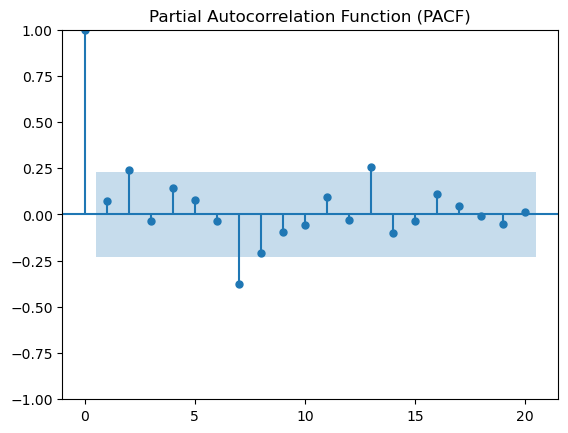

In [176]:
# Plot ACF and PACF
plot_acf(y_sdiff, lags=20, title="Autocorrelation Function (ACF)")
plt.show()
plot_pacf(y_sdiff, lags=20, title="Partial Autocorrelation Function (PACF)")
plt.show()

Clearly a bar out of bounds at 7

In [178]:
model_aic = pm.auto_arima(
    y,
    seasonal=True,
    m=7,           # Weekly seasonality
    D=1,           # Seasonal differencing as specified
    stepwise=False,
    n_jobs=-1,     # Use all processors
    trace=True,
    suppress_warnings=True,
    error_action='ignore',
    information_criterion='aic'
)

print(model_aic.summary())


Best model:  ARIMA(1,0,3)(0,1,1)[7] intercept
Total fit time: 4.716 seconds
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   81
Model:             SARIMAX(1, 0, 3)x(0, 1, [1], 7)   Log Likelihood                -391.588
Date:                             Tue, 26 Aug 2025   AIC                            797.177
Time:                                     17:57:31   BIC                            813.305
Sample:                                 03-13-2015   HQIC                           803.610
                                      - 06-01-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1668      0.

In [179]:
model_bic = pm.auto_arima(
    y,
    seasonal=True,
    m=7,           # Weekly seasonality
    D=1,           # Seasonal differencing as specified
    stepwise=False,
    n_jobs=-1,     # Use all processors
    trace=True,
    suppress_warnings=True,
    error_action='ignore',
    information_criterion='bic'
)

print(model_bic.summary())


Best model:  ARIMA(0,0,0)(0,1,1)[7] intercept
Total fit time: 4.520 seconds
                                 SARIMAX Results                                 
Dep. Variable:                         y   No. Observations:                   81
Model:             SARIMAX(0, 1, [1], 7)   Log Likelihood                -398.781
Date:                   Tue, 26 Aug 2025   AIC                            803.561
Time:                           17:57:36   BIC                            810.474
Sample:                       03-13-2015   HQIC                           806.319
                            - 06-01-2015                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -3.5203      1.433     -2.456      0.014      -6.330      -0.711
ma.S.L7       -0.9205      0.2

The parameters on this option are clearly significant. This is an indication that this model might do better. But we have to verify.

In [180]:
# Generate forecasts from both models
aic_train_pred = model_aic.predict_in_sample()
aic_test_forecast = model_bic.predict(n_periods=14)

bic_train_pred = model_bic.predict_in_sample()
bic_test_forecast = model_bic.predict(n_periods=14)

# Compute metrics
aic_train_metrics = compute_metrics(y_4904_train[8:], aic_train_pred[8:])
aic_test_metrics = compute_metrics(y_4904_test[:14], aic_test_forecast)

bic_train_metrics = compute_metrics(y_4904_train[8:], bic_train_pred[8:])
bic_test_metrics = compute_metrics(y_4904_test[:14], bic_test_forecast)

# Create results table
metrics_df = pd.DataFrame(
    [aic_train_metrics, aic_test_metrics, bic_train_metrics, bic_test_metrics],
    index=['AIC Train', 'AIC Test', 'BIC Train', 'BIC Test']
)

metrics_df

,MAE,RMSE,MAPE,SMAPE
AIC Train,37.060921,47.373311,11.872667,11.974064
AIC Test,27.233321,36.415978,8.842524,8.653098
BIC Train,40.251818,52.346778,13.283942,13.143873
BIC Test,27.233321,36.415978,8.842524,8.653098


In [181]:
# For each store/model combination (example loop below)
store_name = '4904'
model_name = 'Sarima'
rows = ['AIC Train', 'AIC Test']  # or any other row subset

# Select and label the relevant metrics
selected_metrics_df = (
    metrics_df.loc[rows]
    .assign(Store=store_name, Model=model_name)
    .reset_index()
)

# Append to the list
all_metrics.append(selected_metrics_df)

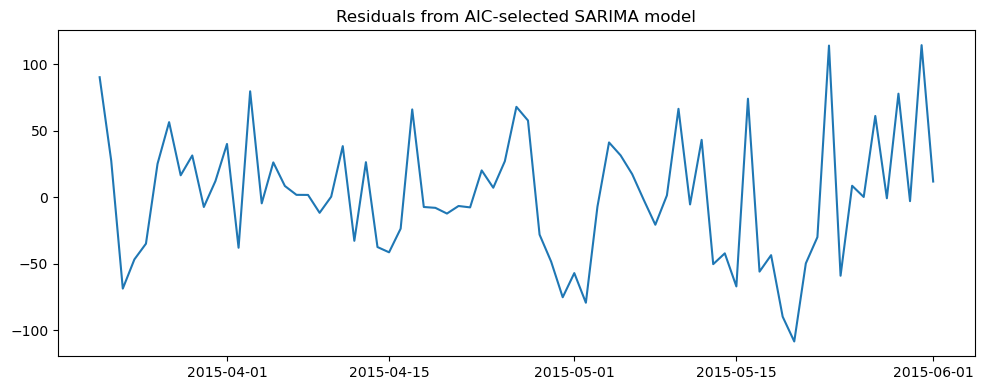

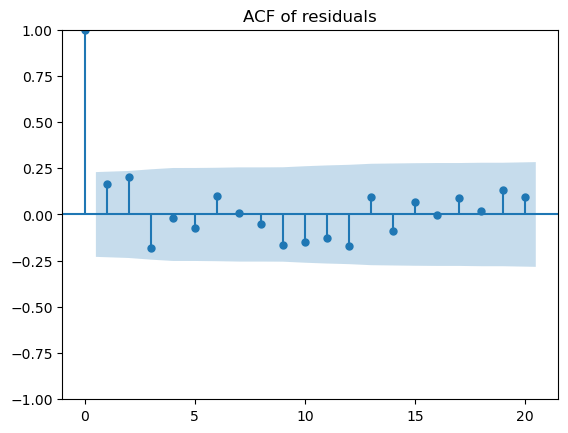

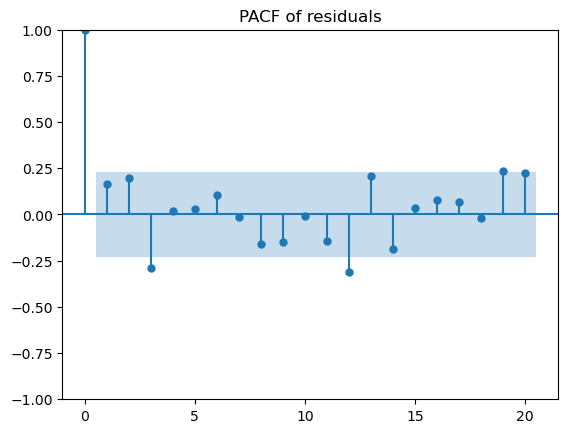


=== Ljung-Box Test for Residuals ===
Lags tested: [25]
Lag 25: p-value = 0.345 -> No significant autocorrelation
Conclusion: No significant autocorrelation detected in residuals.

=== Shapiro-Wilk Test for Normality ===
Statistic: 0.989, p-value: 0.807
Conclusion: Residuals appear to be normally distributed (fail to reject H0).


In [183]:
# Residuals from the already trained model
# Generate fitted values from the model
# Recreate residuals manually from original y
fitted = model_aic.predict_in_sample()
residuals = y - fitted
residuals = residuals.dropna()
residuals = residuals[8:]

# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title("Residuals from AIC-selected SARIMA model")
plt.tight_layout()
plt.show()

# ACF
plot_acf(residuals, lags=20)
plt.title("ACF of residuals")
plt.show()

# PACF
plot_pacf(residuals, lags=20, method="ols")
plt.title("PACF of residuals")
plt.show()

box_test = sm.stats.acorr_ljungbox(residuals, lags=[25], return_df=True)  # Using `return_df` for cleaner output

print("\n=== Ljung-Box Test for Residuals ===")
print(f"Lags tested: {box_test.index.tolist()}")
for lag, pval in zip(box_test.index, box_test['lb_pvalue']):
    print(f"Lag {lag}: p-value = {pval:.3f} -> {'No significant autocorrelation' if pval > 0.05 else 'Significant autocorrelation'}")

# Check overall result
if all(box_test['lb_pvalue'] > 0.05):
    print("Conclusion: No significant autocorrelation detected in residuals.")
else:
    print("Conclusion: Residuals show significant autocorrelation at some lags.")

# Normality test
shapiro_test = shapiro(residuals)
print("\n=== Shapiro-Wilk Test for Normality ===")
print(f"Statistic: {shapiro_test[0]:.3f}, p-value: {shapiro_test[1]:.3f}")
if shapiro_test[1] > 0.05:
    print("Conclusion: Residuals appear to be normally distributed (fail to reject H0).")
else:
    print("Conclusion: Residuals deviate from normality (reject H0).")

# Distribution visualization
mean = np.mean(residuals)
std = np.std(residuals)
mu = mean
sigma = std
x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 100)
pdf = stats.norm.pdf(x, mu, sigma)

In [184]:
# 1. Fit SARIMA(0,0,0)(0,1,1)[7] without drift to full training series
model_4904_final = SARIMAX(
    y_4904,
    order=(1, 0, 3),
    seasonal_order=(0, 1, 1, 7),
    trend='n'
).fit()

# 2. Forecast 14 steps ahead
forecast_values = model_4904_final.forecast(steps=14)

# 3. Estimate residual standard deviation
resid_std = np.std(model_4904_final.resid, ddof=1)

# 4. Create confidence intervals manually (normal approx)
z_80 = 1.28  # 80% CI
z_95 = 1.96  # 95% CI

forecast_df = pd.DataFrame({
    'Point Forecast': forecast_values,
    'Low 80': forecast_values - z_80 * resid_std,
    'High 80': forecast_values + z_80 * resid_std,
    'Low 95': forecast_values - z_95 * resid_std,
    'High 95': forecast_values + z_95 * resid_std
})

# 5. Assign forecast dates as index
forecast_df.index = pd.date_range(start=y_4904.index[-1] + pd.Timedelta(days=1), periods=14, freq='D')
forecast_df = forecast_df.round(2)

# Display
y_4904_sarima_fc = forecast_df
y_4904_sarima_fc 

,Point Forecast,Low 80,High 80,Low 95,High 95
2015-06-16,359.08,233.76,484.40,167.18,550.98
2015-06-17,343.51,218.19,468.83,151.61,535.41
2015-06-18,305.83,180.51,431.16,113.93,497.73
2015-06-19,220.87,95.55,346.19,28.97,412.77
2015-06-20,222.35,97.02,347.67,30.45,414.25
2015-06-21,346.98,221.65,472.30,155.08,538.88
2015-06-22,341.91,216.58,467.23,150.01,533.80
2015-06-23,361.42,236.10,486.75,169.52,553.32
2015-06-24,346.56,221.24,471.88,154.66,538.46
2015-06-25,308.57,183.25,433.89,116.67,500.47


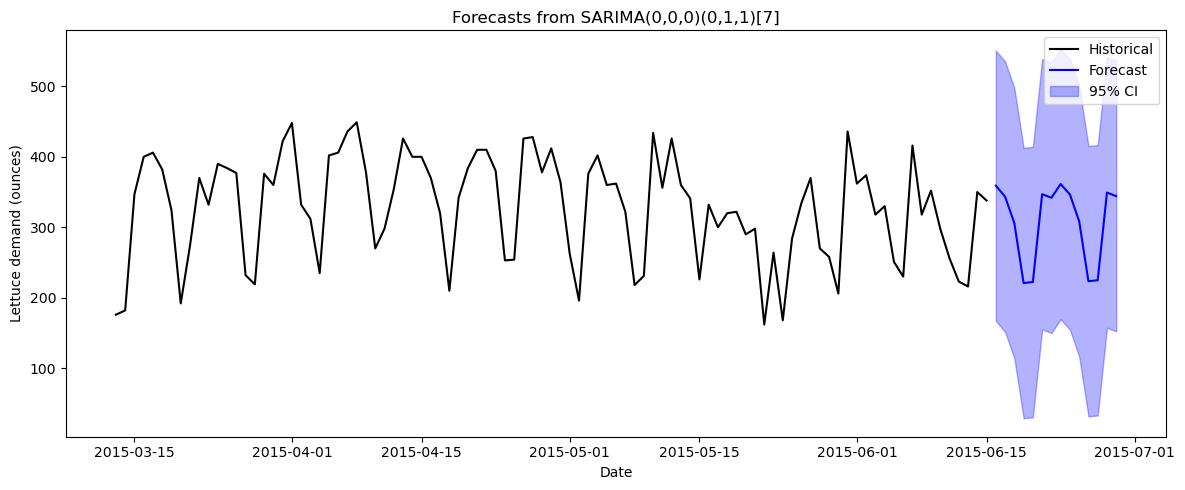

In [185]:
# 1. Plot historical data
plt.figure(figsize=(12, 5))
plt.plot(y_4904, label='Historical', color='black')

# 2. Plot point forecast
plt.plot(forecast_df.index, forecast_df['Point Forecast'], label='Forecast', color='blue')

# 3. Add shaded 80% and 95% intervals
plt.fill_between(forecast_df.index,
                 forecast_df['Low 95'],
                 forecast_df['High 95'],
                 color='blue', alpha=0.3, label='95% CI')

# 4. Final touches
plt.title("Forecasts from SARIMA(0,0,0)(0,1,1)[7]")
plt.xlabel("Date")
plt.ylabel("Lettuce demand (ounces)")
plt.legend()
plt.tight_layout()
plt.show()

### 3.3 Store 20974

In [191]:
y = y_20974_train.copy()

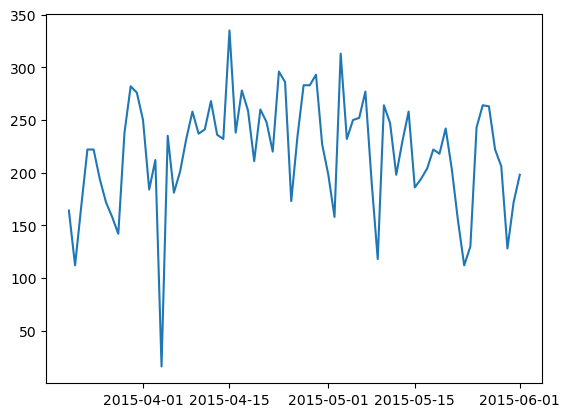

In [193]:
plt.plot(y)
plt.show()

In [196]:
from scipy.stats import kurtosis, skew

#Basic statistics
mean = np.mean(y)
std = np.std(y)
kurtosis = kurtosis(y)
skewness = skew(y)

print("Mean",mean,"Standard deviation",std,"Skewness", skewness, "Kurtosis",kurtosis)

Mean 218.98648648648648 Standard deviation 53.56670336390735 Skewness -0.839099815728848 Kurtosis 1.5534632435511861


In [198]:
# Test for 0 mean
# H0: The mean of the series is equal to 0
# H1: The mean of the series is not equal to 0

t_statistic, p_value = stats.ttest_1samp(y, 0)

print(f"T-statistic: {t_statistic}")
if p_value < 0.05:
    print(f"We reject H0 that the mean is 0 with a p-value of {p_value}")
else:
    print(f"We do not reject H0 that the mean is 0 with a p-value of {p_value}")

T-statistic: 34.928812923274656
We reject H0 that the mean is 0 with a p-value of 2.622609002735114e-47


In [200]:
# Shapiro-Wilk test for normality:

# H0: The data follows a normal distribution
# H1: The data does not follow a normal distribution

alpha = 0.05

shapiro_test = shapiro(y)
print("Shapiro-Wilk Test for Normality")
print("Test Statistic:", shapiro_test.statistic)
print("p-value:", shapiro_test.pvalue)

# Interpret the result of the Shapiro-Wilk test
if shapiro_test.pvalue < alpha:
    print(f"We reject H0: the data does not follow a normal distribution (p-value = {shapiro_test.pvalue:.4f})")
else:
    print(f"We do not reject H0: the data follows a normal distribution (p-value = {shapiro_test.pvalue:.4f})")

Shapiro-Wilk Test for Normality
Test Statistic: 0.9612233638763428
p-value: 0.022944778203964233
We reject H0: the data does not follow a normal distribution (p-value = 0.0229)


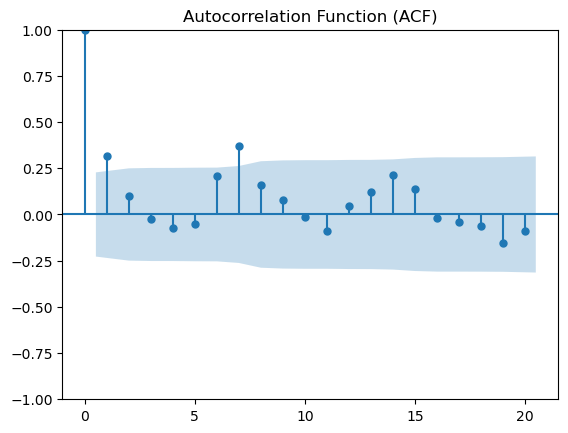

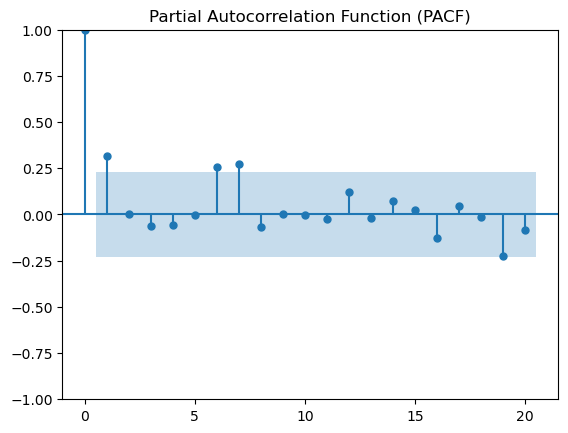

In [202]:
# Plot ACF and PACF
plot_acf(y, lags=20, title="Autocorrelation Function (ACF)")
plt.show()
plot_pacf(y, lags=20, title="Partial Autocorrelation Function (PACF)")
plt.show()

We have no zero mean, rejected normal distribution and have visibly bars out of bounds. We have to test options for differencing.

In [204]:
# Assuming weekly seasonality
D_ch = nsdiffs(y_20974_train, m=7, test='ch')
D_ocsb = nsdiffs(y_20974_train, m=7, test='ocsb')

print(f"CH Test (like R): Seasonal differences needed = {D_ch}")
print(f"OCSB Test (default): Seasonal differences needed = {D_ocsb}")

CH Test (like R): Seasonal differences needed = 0
OCSB Test (default): Seasonal differences needed = 0


The test result here is contradictory, as we see clearly recurring bars in weekly seasonality in the ACF. Seasonal differencing will be applied.

In [206]:
seasonal_period = 7
y_sdiff = y.diff(seasonal_period).dropna()

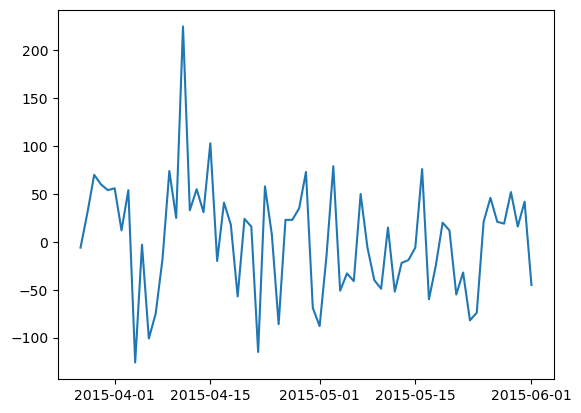

In [208]:
plt.plot(y_sdiff)
plt.show()

In [210]:
from scipy.stats import kurtosis, skew

# Basic statistics
mean = np.mean(y_sdiff)
std = np.std(y_sdiff)
kurtosis = kurtosis(y_sdiff)
skewness = skew(y_sdiff)

print("Mean",mean,"Standard deviation",std,"Skewness", skewness, "Kurtosis",kurtosis)

Mean 2.970149253731343 Standard deviation 58.862341342626976 Skewness 0.3968152406196587 Kurtosis 1.5814072598064879


In [212]:
# Test for 0 mean
# H0: The mean of the series is equal to 0
# H1: The mean of the series is not equal to 0

t_statistic, p_value = stats.ttest_1samp(y_sdiff, 0)

print(f"T-statistic: {t_statistic}")
if p_value < 0.05:
    print(f"We reject H0 that the mean is 0 with a p-value of {p_value}")
else:
    print(f"We do not reject H0 that the mean is 0 with a p-value of {p_value}")

T-statistic: 0.40993283743778086
We do not reject H0 that the mean is 0 with a p-value of 0.6831827905461116


In [214]:
print("\n===> Stationarity Tests on Seasonally Differenced Series (y_sdiff) <===\n")

# ADF Test
adf_result = adfuller(y_sdiff)
print("ADF Test:")
print(f"  Test Statistic = {adf_result[0]:.4f}")
print(f"  p-value        = {adf_result[1]:.4f}")
if adf_result[1] < 0.05:
    print("  Reject H0: The series is likely stationary.\n")
else:
    print("  Fail to Reject H0: The series is likely non-stationary.\n")

# Phillips-Perron Test
pp_result = PhillipsPerron(y_sdiff)
print("Phillips-Perron (PP) Test:")
print(f"  Test Statistic = {pp_result.stat:.4f}")
print(f"  p-value        = {pp_result.pvalue:.4f}")
if pp_result.pvalue < 0.05:
    print("  Reject H0: The series is likely stationary.\n")
else:
    print("  Fail to Reject H0: The series is likely non-stationary.\n")

# KPSS Test
kpss_stat, kpss_pval, _, _ = kpss(y_sdiff, regression='c', nlags="auto")
print("KPSS Test:")
print(f"  Test Statistic = {kpss_stat:.4f}")
print(f"  p-value        = {kpss_pval:.4f}")
if kpss_pval > 0.05:
    print("  Fail to Reject H0: The series is likely stationary.\n")
else:
    print("  Reject H0: The series is likely non-stationary.\n")


===> Stationarity Tests on Seasonally Differenced Series (y_sdiff) <===

ADF Test:
  Test Statistic = -4.5967
  p-value        = 0.0001
  Reject H0: The series is likely stationary.

Phillips-Perron (PP) Test:
  Test Statistic = -6.8155
  p-value        = 0.0000
  Reject H0: The series is likely stationary.

KPSS Test:
  Test Statistic = 0.2391
  p-value        = 0.1000
  Fail to Reject H0: The series is likely stationary.



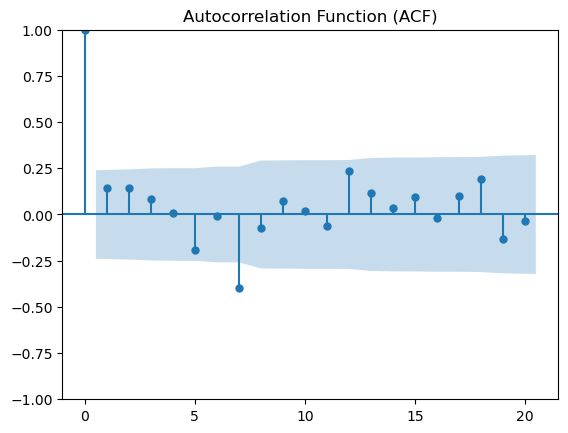

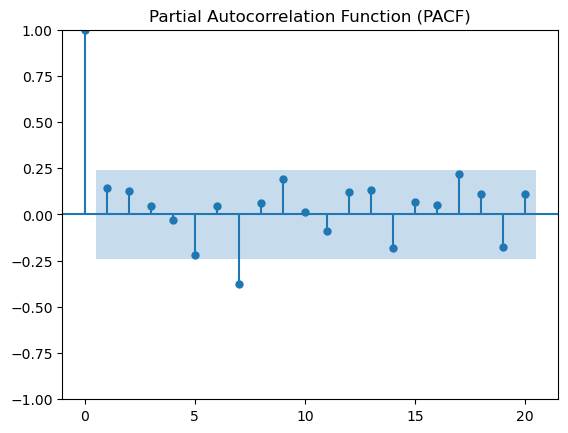

In [216]:
# Plot ACF and PACF
plot_acf(y_sdiff, lags=20, title="Autocorrelation Function (ACF)")
plt.show()
plot_pacf(y_sdiff, lags=20, title="Partial Autocorrelation Function (PACF)")
plt.show()

Clearly a bar out of bounds at 7

In [218]:
model_aic = pm.auto_arima(
    y,
    seasonal=True,
    m=7,           # Weekly seasonality
    D=1,           # Seasonal differencing as specified
    stepwise=False,
    n_jobs=-1,     # Use all processors
    trace=True,
    suppress_warnings=True,
    error_action='ignore',
    information_criterion='aic'
)

print(model_aic.summary())


Best model:  ARIMA(1,0,1)(2,1,0)[7] intercept
Total fit time: 4.221 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   74
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 7)   Log Likelihood                -359.194
Date:                            Tue, 26 Aug 2025   AIC                            730.389
Time:                                    17:58:01   BIC                            743.617
Sample:                                03-20-2015   HQIC                           735.623
                                     - 06-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3375      1.843     

In [219]:
model_bic = pm.auto_arima(
    y,
    seasonal=True,
    m=7,           # Weekly seasonality
    D=1,           # Seasonal differencing as specified
    stepwise=False,
    n_jobs=-1,     # Use all processors
    trace=True,
    suppress_warnings=True,
    error_action='ignore',
    information_criterion='bic'
)

print(model_bic.summary())


Best model:  ARIMA(0,0,0)(1,1,0)[7] intercept
Total fit time: 4.417 seconds
                                SARIMAX Results                                
Dep. Variable:                       y   No. Observations:                   74
Model:             SARIMAX(1, 1, 0, 7)   Log Likelihood                -362.317
Date:                 Tue, 26 Aug 2025   AIC                            730.634
Time:                         17:58:06   BIC                            737.248
Sample:                     03-20-2015   HQIC                           733.251
                          - 06-01-2015                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.7335      6.792      0.255      0.799     -11.579      15.046
ar.S.L7       -0.3982      0.083     -4.811   

The parameters on this option are clearly significant. This is an indication that this model might do better. But we have to verify.

In [220]:
# Generate forecasts from both models
aic_train_pred = model_aic.predict_in_sample()
aic_test_forecast = model_bic.predict(n_periods=14)

bic_train_pred = model_bic.predict_in_sample()
bic_test_forecast = model_bic.predict(n_periods=14)

# Compute metrics
aic_train_metrics = compute_metrics(y_20974_train[8:], aic_train_pred[8:])
aic_test_metrics = compute_metrics(y_20974_test[:14], aic_test_forecast)

bic_train_metrics = compute_metrics(y_20974_train[8:], bic_train_pred[8:])
bic_test_metrics = compute_metrics(y_20974_test[:14], bic_test_forecast)

# Create results table
metrics_df = pd.DataFrame(
    [aic_train_metrics, aic_test_metrics, bic_train_metrics, bic_test_metrics],
    index=['AIC Train', 'AIC Test', 'BIC Train', 'BIC Test']
)

metrics_df

,MAE,RMSE,MAPE,SMAPE
AIC Train,41.452661,51.755514,31.166958,20.716465
AIC Test,35.499732,55.586364,14.560878,16.365539
BIC Train,43.274722,54.236851,30.468374,21.847991
BIC Test,35.499732,55.586364,14.560878,16.365539


In [222]:
# For each store/model combination (example loop below)
store_name = '20974'
model_name = 'Sarima'
rows = ['AIC Train', 'AIC Test']  # or any other row subset

# Select and label the relevant metrics
selected_metrics_df = (
    metrics_df.loc[rows]
    .assign(Store=store_name, Model=model_name)
    .reset_index()
)

# Append to the list
all_metrics.append(selected_metrics_df)

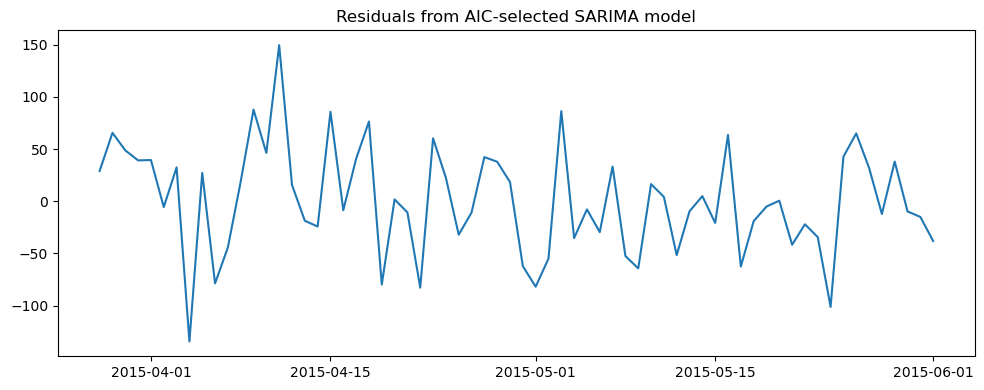

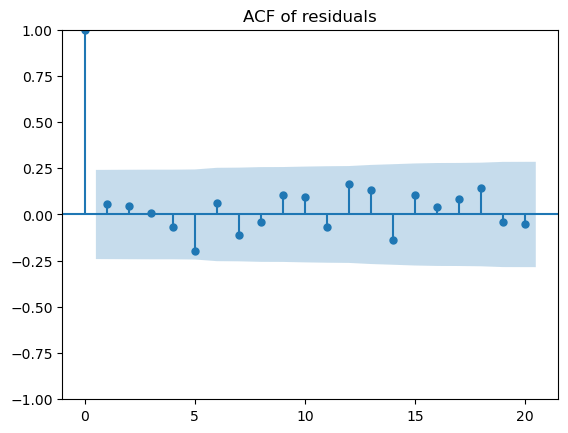

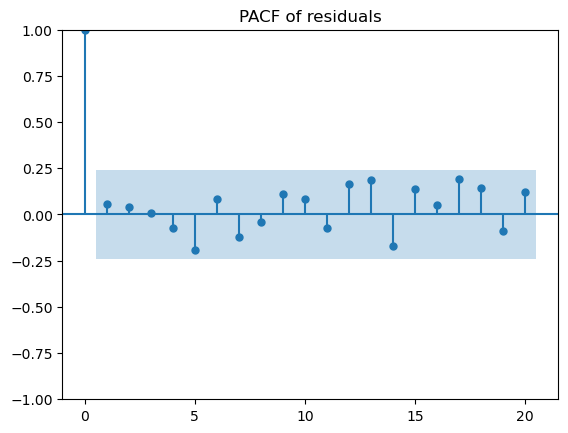


=== Ljung-Box Test for Residuals ===
Lags tested: [25]
Lag 25: p-value = 0.543 -> No significant autocorrelation
Conclusion: No significant autocorrelation detected in residuals.

=== Shapiro-Wilk Test for Normality ===
Statistic: 0.993, p-value: 0.964
Conclusion: Residuals appear to be normally distributed (fail to reject H0).


In [223]:
# Residuals from the already trained model
# Generate fitted values from the model
# Recreate residuals manually from original y
fitted = model_aic.predict_in_sample()
residuals = y - fitted
residuals = residuals.dropna()
residuals = residuals[8:]

# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title("Residuals from AIC-selected SARIMA model")
plt.tight_layout()
plt.show()

# ACF
plot_acf(residuals, lags=20)
plt.title("ACF of residuals")
plt.show()

# PACF
plot_pacf(residuals, lags=20, method="ols")
plt.title("PACF of residuals")
plt.show()

box_test = sm.stats.acorr_ljungbox(residuals, lags=[25], return_df=True)  # Using `return_df` for cleaner output

print("\n=== Ljung-Box Test for Residuals ===")
print(f"Lags tested: {box_test.index.tolist()}")
for lag, pval in zip(box_test.index, box_test['lb_pvalue']):
    print(f"Lag {lag}: p-value = {pval:.3f} -> {'No significant autocorrelation' if pval > 0.05 else 'Significant autocorrelation'}")

# Check overall result
if all(box_test['lb_pvalue'] > 0.05):
    print("Conclusion: No significant autocorrelation detected in residuals.")
else:
    print("Conclusion: Residuals show significant autocorrelation at some lags.")

# Normality test
shapiro_test = shapiro(residuals)
print("\n=== Shapiro-Wilk Test for Normality ===")
print(f"Statistic: {shapiro_test[0]:.3f}, p-value: {shapiro_test[1]:.3f}")
if shapiro_test[1] > 0.05:
    print("Conclusion: Residuals appear to be normally distributed (fail to reject H0).")
else:
    print("Conclusion: Residuals deviate from normality (reject H0).")

# Distribution visualization
mean = np.mean(residuals)
std = np.std(residuals)
mu = mean
sigma = std
x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 100)
pdf = stats.norm.pdf(x, mu, sigma)

In [228]:
# 1. Fit SARIMA(0,0,0)(0,1,1)[7] without drift to full training series
model_20974_final = SARIMAX(
    y_20974,
    order=(1, 0, 1),
    seasonal_order=(2, 1, 0, 7),
    trend='n'
).fit()

# 2. Forecast 14 steps ahead
forecast_values = model_20974_final.forecast(steps=14)

# 3. Estimate residual standard deviation
resid_std = np.std(model_20974_final.resid, ddof=1)

# 4. Create confidence intervals manually (normal approx)
z_80 = 1.28  # 80% CI
z_95 = 1.96  # 95% CI

forecast_df = pd.DataFrame({
    'Point Forecast': forecast_values,
    'Low 80': forecast_values - z_80 * resid_std,
    'High 80': forecast_values + z_80 * resid_std,
    'Low 95': forecast_values - z_95 * resid_std,
    'High 95': forecast_values + z_95 * resid_std
})

# 5. Assign forecast dates as index
forecast_df.index = pd.date_range(start=y_20974.index[-1] + pd.Timedelta(days=1), periods=14, freq='D')
forecast_df = forecast_df.round(2)

# Display
y_20974_sarima_fc = forecast_df
y_20974_sarima_fc

,Point Forecast,Low 80,High 80,Low 95,High 95
2015-06-16,248.24,159.44,337.03,112.27,384.20
2015-06-17,272.68,183.88,361.47,136.71,408.64
2015-06-18,311.72,222.92,400.51,175.75,447.68
2015-06-19,197.39,108.59,286.18,61.42,333.35
2015-06-20,184.36,95.57,273.16,48.40,320.33
2015-06-21,187.60,98.80,276.39,51.63,323.56
2015-06-22,245.69,156.90,334.48,109.72,381.66
2015-06-23,241.51,152.71,330.30,105.54,377.47
2015-06-24,269.57,180.77,358.36,133.60,405.54
2015-06-25,311.26,222.47,400.06,175.30,447.23


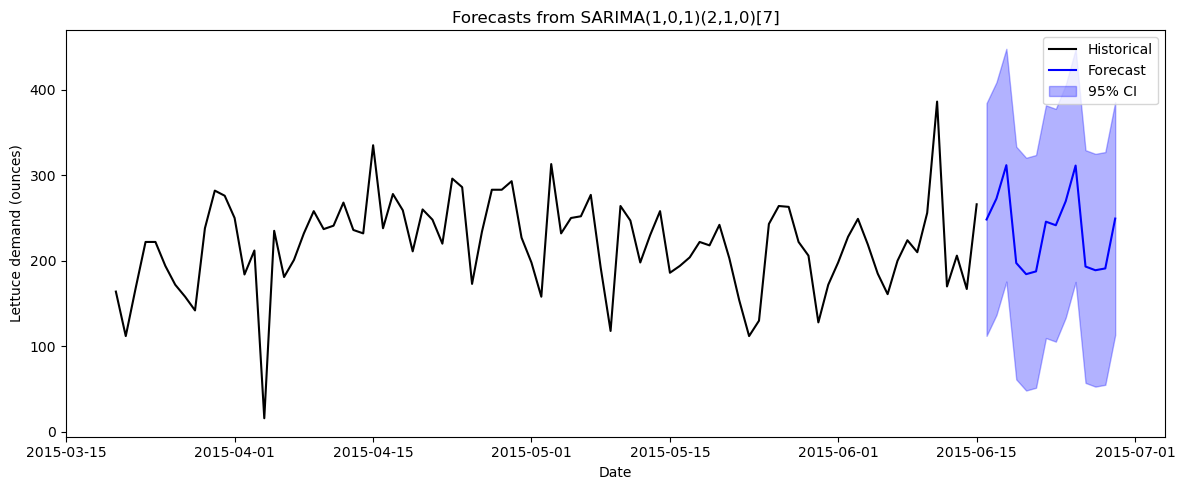

In [230]:
# 1. Plot historical data
plt.figure(figsize=(12, 5))
plt.plot(y_20974, label='Historical', color='black')

# 2. Plot point forecast
plt.plot(forecast_df.index, forecast_df['Point Forecast'], label='Forecast', color='blue')

# 3. Add shaded 80% and 95% intervals
plt.fill_between(forecast_df.index,
                 forecast_df['Low 95'],
                 forecast_df['High 95'],
                 color='blue', alpha=0.3, label='95% CI')

# 4. Final touches
plt.title("Forecasts from SARIMA(1,0,1)(2,1,0)[7]")
plt.xlabel("Date")
plt.ylabel("Lettuce demand (ounces)")
plt.legend()
plt.tight_layout()
plt.show()

### 3.4 Store 12631

In [232]:
y = y_12631_train.copy()

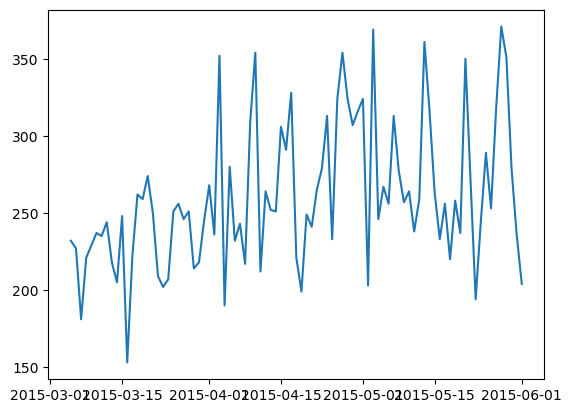

In [234]:
plt.plot(y)
plt.show()

In [236]:
from scipy.stats import kurtosis, skew

# Basic statistics
mean = np.mean(y)
std = np.std(y)
kurtosis = kurtosis(y)
skewness = skew(y)

print("Mean",mean,"Standard deviation",std,"Skewness", skewness, "Kurtosis",kurtosis)

Mean 260.4831460674157 Standard deviation 46.83178416502822 Skewness 0.5651590764257044 Kurtosis -0.1913426625003467


In [238]:
# Test for 0 mean
# H0: The mean of the series is equal to 0
# H1: The mean of the series is not equal to 0

t_statistic, p_value = stats.ttest_1samp(y, 0)

print(f"T-statistic: {t_statistic}")
if p_value < 0.05:
    print(f"We reject H0 that the mean is 0 with a p-value of {p_value}")
else:
    print(f"We do not reject H0 that the mean is 0 with a p-value of {p_value}")

T-statistic: 52.17713889257965
We reject H0 that the mean is 0 with a p-value of 5.575588087931243e-68


In [240]:
# Shapiro-Wilk test for normality:

# H0: The data follows a normal distribution
# H1: The data does not follow a normal distribution

alpha = 0.05

shapiro_test = shapiro(y)
print("Shapiro-Wilk Test for Normality")
print("Test Statistic:", shapiro_test.statistic)
print("p-value:", shapiro_test.pvalue)

# Interpret the result of the Shapiro-Wilk test
if shapiro_test.pvalue < alpha:
    print(f"We reject H0: the data does not follow a normal distribution (p-value = {shapiro_test.pvalue:.4f})")
else:
    print(f"We do not reject H0: the data follows a normal distribution (p-value = {shapiro_test.pvalue:.4f})")

Shapiro-Wilk Test for Normality
Test Statistic: 0.9546216726303101
p-value: 0.0034887169022113085
We reject H0: the data does not follow a normal distribution (p-value = 0.0035)


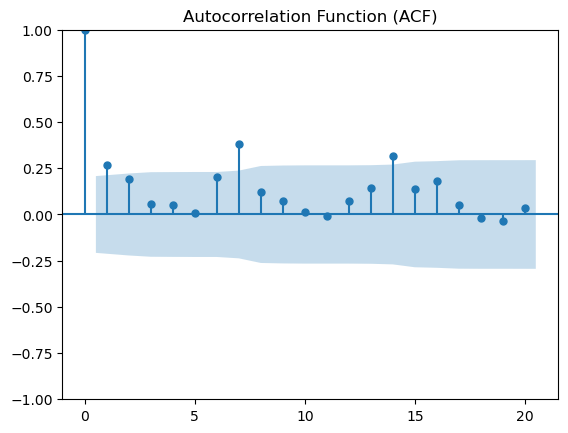

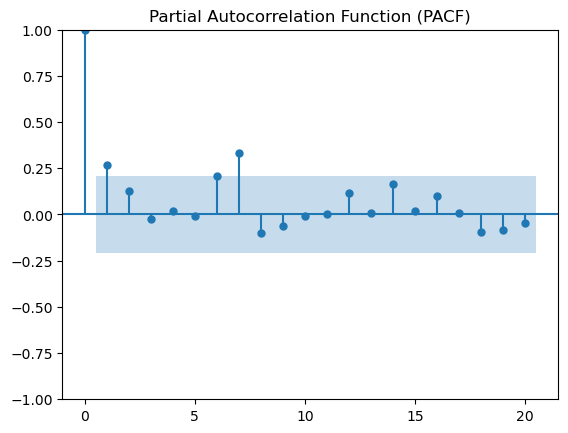

In [242]:
# Plot ACF and PACF
plot_acf(y, lags=20, title="Autocorrelation Function (ACF)")
plt.show()
plot_pacf(y, lags=20, title="Partial Autocorrelation Function (PACF)")
plt.show()

We have no zero mean, rejected normal distribution and have visibly bars out of bounds. We have to test options for differencing.

In [244]:
# Assuming weekly seasonality
D_ch = nsdiffs(y_12631_train, m=7, test='ch')
D_ocsb = nsdiffs(y_12631_train, m=7, test='ocsb')

print(f"CH Test (like R): Seasonal differences needed = {D_ch}")
print(f"OCSB Test (default): Seasonal differences needed = {D_ocsb}")

CH Test (like R): Seasonal differences needed = 0
OCSB Test (default): Seasonal differences needed = 0


The test result here is contradictory, as we see clearly recurring bars in weekly seasonality in the ACF. Seasonal differencing will be applied.

In [246]:
seasonal_period = 7
y_sdiff = y.diff(seasonal_period).dropna()

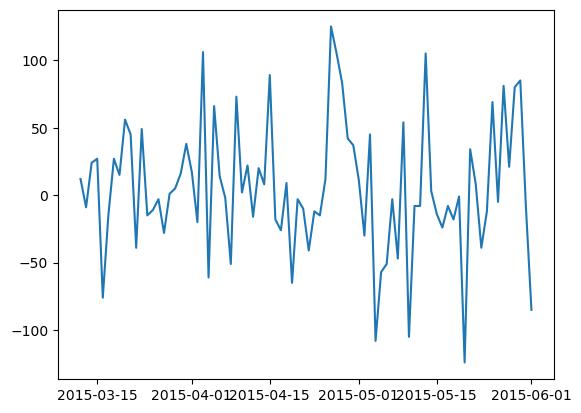

In [248]:
plt.plot(y_sdiff)
plt.show()

In [250]:
from scipy.stats import kurtosis, skew

# Basic statistics
mean = np.mean(y_sdiff)
std = np.std(y_sdiff)
kurtosis = kurtosis(y_sdiff)
skewness = skew(y_sdiff)

print("Mean",mean,"Standard deviation",std,"Skewness", skewness, "Kurtosis",kurtosis)

Mean 5.487804878048781 Standard deviation 49.326004595221185 Skewness 0.031406989073197035 Kurtosis 0.2562730455721227


In [252]:
# Test for 0 mean
# H0: The mean of the series is equal to 0
# H1: The mean of the series is not equal to 0

t_statistic, p_value = stats.ttest_1samp(y_sdiff, 0)

print(f"T-statistic: {t_statistic}")
if p_value < 0.05:
    print(f"We reject H0 that the mean is 0 with a p-value of {p_value}")
else:
    print(f"We do not reject H0 that the mean is 0 with a p-value of {p_value}")

T-statistic: 1.0013023415892897
We do not reject H0 that the mean is 0 with a p-value of 0.31966258315092533


In [254]:
print("\n===> Stationarity Tests on Seasonally Differenced Series (y_sdiff) <===\n")

# ADF Test
adf_result = adfuller(y_sdiff)
print("ADF Test:")
print(f"  Test Statistic = {adf_result[0]:.4f}")
print(f"  p-value        = {adf_result[1]:.4f}")
if adf_result[1] < 0.05:
    print("  Reject H0: The series is likely stationary.\n")
else:
    print("  Fail to Reject H0: The series is likely non-stationary.\n")

# Phillips-Perron Test
pp_result = PhillipsPerron(y_sdiff)
print("Phillips-Perron (PP) Test:")
print(f"  Test Statistic = {pp_result.stat:.4f}")
print(f"  p-value        = {pp_result.pvalue:.4f}")
if pp_result.pvalue < 0.05:
    print("  Reject H0: The series is likely stationary.\n")
else:
    print("  Fail to Reject H0: The series is likely non-stationary.\n")

# KPSS Test
kpss_stat, kpss_pval, _, _ = kpss(y_sdiff, regression='c', nlags="auto")
print("KPSS Test:")
print(f"  Test Statistic = {kpss_stat:.4f}")
print(f"  p-value        = {kpss_pval:.4f}")
if kpss_pval > 0.05:
    print("  Fail to Reject H0: The series is likely stationary.\n")
else:
    print("  Reject H0: The series is likely non-stationary.\n")


===> Stationarity Tests on Seasonally Differenced Series (y_sdiff) <===

ADF Test:
  Test Statistic = -5.0566
  p-value        = 0.0000
  Reject H0: The series is likely stationary.

Phillips-Perron (PP) Test:
  Test Statistic = -8.2483
  p-value        = 0.0000
  Reject H0: The series is likely stationary.

KPSS Test:
  Test Statistic = 0.0584
  p-value        = 0.1000
  Fail to Reject H0: The series is likely stationary.



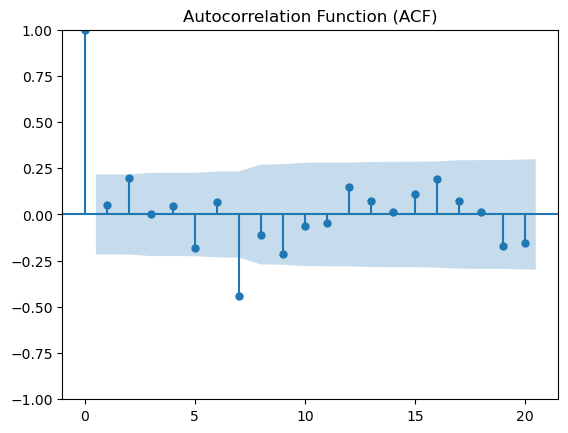

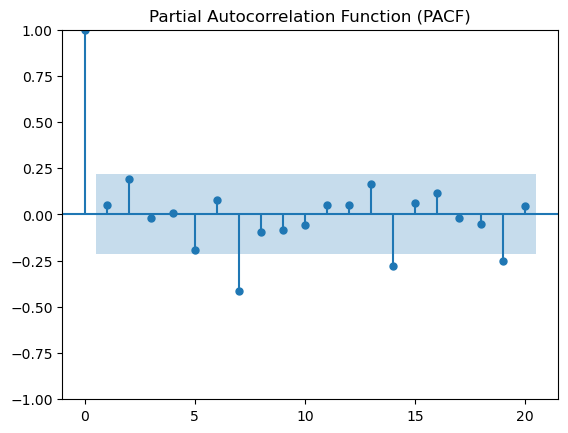

In [256]:
# Plot ACF and PACF
plot_acf(y_sdiff, lags=20, title="Autocorrelation Function (ACF)")
plt.show()
plot_pacf(y_sdiff, lags=20, title="Partial Autocorrelation Function (PACF)")
plt.show()

Clearly a bar out of bounds at 7

In [258]:
model_aic = pm.auto_arima(
    y,
    seasonal=True,
    m=7,           # Weekly seasonality
    D=1,           # Seasonal differencing as specified
    stepwise=False,
    n_jobs=-1,     # Use all processors
    trace=True,
    suppress_warnings=True,
    error_action='ignore',
    information_criterion='aic'
)

print(model_aic.summary())


Best model:  ARIMA(0,0,0)(0,1,1)[7] intercept
Total fit time: 4.818 seconds
                                 SARIMAX Results                                 
Dep. Variable:                         y   No. Observations:                   89
Model:             SARIMAX(0, 1, [1], 7)   Log Likelihood                -420.590
Date:                   Tue, 26 Aug 2025   AIC                            847.179
Time:                           17:58:40   BIC                            854.399
Sample:                       03-05-2015   HQIC                           850.078
                            - 06-01-2015                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.2239      1.110      4.706      0.000       3.048       7.399
ma.S.L7       -0.9202      0.2

In [259]:
model_bic = pm.auto_arima(
    y,
    seasonal=True,
    m=7,           # Weekly seasonality
    D=1,           # Seasonal differencing as specified
    stepwise=False,
    n_jobs=-1,     # Use all processors
    trace=True,
    suppress_warnings=True,
    error_action='ignore',
    information_criterion='bic'
)

print(model_bic.summary())


Best model:  ARIMA(0,0,0)(0,1,1)[7] intercept
Total fit time: 4.740 seconds
                                 SARIMAX Results                                 
Dep. Variable:                         y   No. Observations:                   89
Model:             SARIMAX(0, 1, [1], 7)   Log Likelihood                -420.590
Date:                   Tue, 26 Aug 2025   AIC                            847.179
Time:                           17:58:45   BIC                            854.399
Sample:                       03-05-2015   HQIC                           850.078
                            - 06-01-2015                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.2239      1.110      4.706      0.000       3.048       7.399
ma.S.L7       -0.9202      0.2

The parameters on this option are clearly significant. This is an indication that this model might do better. But we have to verify.

In [260]:
# Generate forecasts from both models
aic_train_pred = model_aic.predict_in_sample()
aic_test_forecast = model_bic.predict(n_periods=14)

bic_train_pred = model_bic.predict_in_sample()
bic_test_forecast = model_bic.predict(n_periods=14)

# Compute metrics
aic_train_metrics = compute_metrics(y_12631_train[8:], aic_train_pred[8:])
aic_test_metrics = compute_metrics(y_12631_test[:14], aic_test_forecast)

bic_train_metrics = compute_metrics(y_12631_train[8:], bic_train_pred[8:])
bic_test_metrics = compute_metrics(y_12631_test[:14], bic_test_forecast)


# Create results table
metrics_df = pd.DataFrame(
    [aic_train_metrics, aic_test_metrics, bic_train_metrics, bic_test_metrics],
    index=['AIC Train', 'AIC Test', 'BIC Train', 'BIC Test']
)

metrics_df

,MAE,RMSE,MAPE,SMAPE
AIC Train,32.103856,40.306598,12.307638,12.155151
AIC Test,43.609356,50.260635,17.400737,15.678234
BIC Train,32.103856,40.306598,12.307638,12.155151
BIC Test,43.609356,50.260635,17.400737,15.678234


In [261]:
# For each store/model combination (example loop below)
store_name = '12631'
model_name = 'Sarima'
rows = ['AIC Train', 'AIC Test']  # or any other row subset

# Select and label the relevant metrics
selected_metrics_df = (
    metrics_df.loc[rows]
    .assign(Store=store_name, Model=model_name)
    .reset_index()
)

# Append to the list
all_metrics.append(selected_metrics_df)

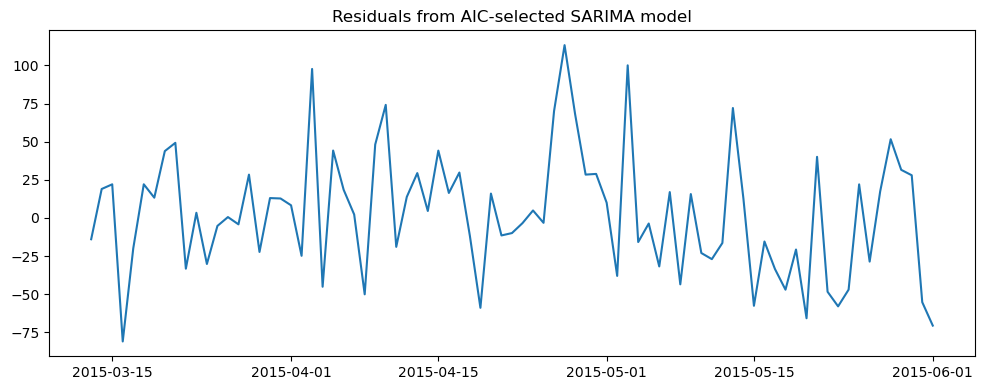

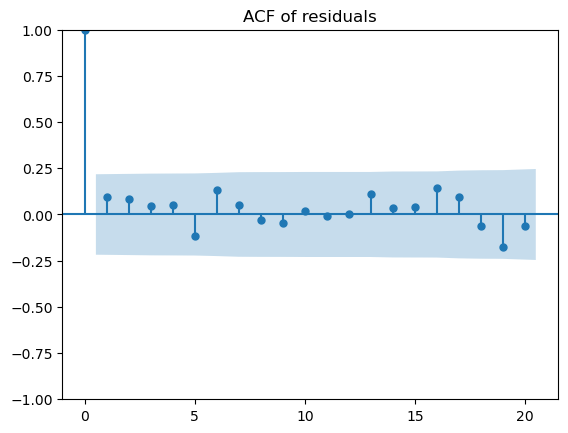

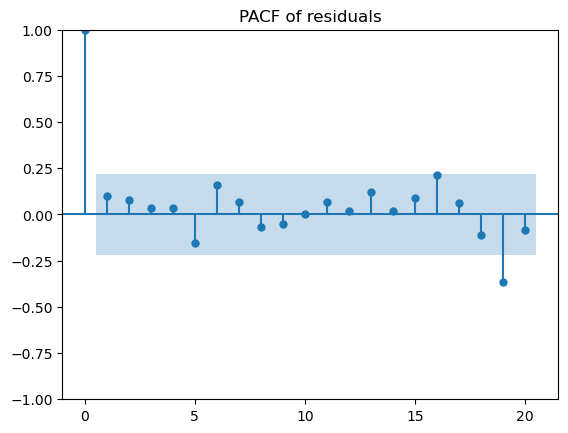


=== Ljung-Box Test for Residuals ===
Lags tested: [25]
Lag 25: p-value = 0.904 -> No significant autocorrelation
Conclusion: No significant autocorrelation detected in residuals.

=== Shapiro-Wilk Test for Normality ===
Statistic: 0.984, p-value: 0.406
Conclusion: Residuals appear to be normally distributed (fail to reject H0).


In [263]:
# Residuals from the already trained model
# Generate fitted values from the model
# Recreate residuals manually from original y
fitted = model_aic.predict_in_sample()
residuals = y - fitted
residuals = residuals.dropna()
residuals = residuals[8:]

# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title("Residuals from AIC-selected SARIMA model")
plt.tight_layout()
plt.show()

# ACF
plot_acf(residuals, lags=20)
plt.title("ACF of residuals")
plt.show()

# PACF
plot_pacf(residuals, lags=20, method="ols")
plt.title("PACF of residuals")
plt.show()

box_test = sm.stats.acorr_ljungbox(residuals, lags=[25], return_df=True)  # Using `return_df` for cleaner output

print("\n=== Ljung-Box Test for Residuals ===")
print(f"Lags tested: {box_test.index.tolist()}")
for lag, pval in zip(box_test.index, box_test['lb_pvalue']):
    print(f"Lag {lag}: p-value = {pval:.3f} -> {'No significant autocorrelation' if pval > 0.05 else 'Significant autocorrelation'}")

# Check overall result
if all(box_test['lb_pvalue'] > 0.05):
    print("Conclusion: No significant autocorrelation detected in residuals.")
else:
    print("Conclusion: Residuals show significant autocorrelation at some lags.")

# Normality test
shapiro_test = shapiro(residuals)
print("\n=== Shapiro-Wilk Test for Normality ===")
print(f"Statistic: {shapiro_test[0]:.3f}, p-value: {shapiro_test[1]:.3f}")
if shapiro_test[1] > 0.05:
    print("Conclusion: Residuals appear to be normally distributed (fail to reject H0).")
else:
    print("Conclusion: Residuals deviate from normality (reject H0).")

# Distribution visualization
mean = np.mean(residuals)
std = np.std(residuals)
mu = mean
sigma = std
x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 100)
pdf = stats.norm.pdf(x, mu, sigma)

In [264]:
# 1. Fit SARIMA(0,0,0)(0,1,1)[7] without drift to full training series
model_12631_final = SARIMAX(
    y_12631,
    order=(0, 0, 0),
    seasonal_order=(0, 1, 1, 7),
    trend='n'
).fit()

# 2. Forecast 14 steps ahead
forecast_values = model_12631_final.forecast(steps=14)

# 3. Estimate residual standard deviation
resid_std = np.std(model_12631_final.resid, ddof=1)

# 4. Create confidence intervals manually (normal approx)
z_80 = 1.28  # 80% CI
z_95 = 1.96  # 95% CI

forecast_df = pd.DataFrame({
    'Point Forecast': forecast_values,
    'Low 80': forecast_values - z_80 * resid_std,
    'High 80': forecast_values + z_80 * resid_std,
    'Low 95': forecast_values - z_95 * resid_std,
    'High 95': forecast_values + z_95 * resid_std
})

# 5. Assign forecast dates as index
forecast_df.index = pd.date_range(start=y_12631.index[-1] + pd.Timedelta(days=1), periods=14, freq='D')
forecast_df = forecast_df.round(2)

# Display
y_12631_sarima_fc = forecast_df
y_12631_sarima_fc

,Point Forecast,Low 80,High 80,Low 95,High 95
2015-06-16,269.47,183.00,355.93,137.06,401.87
2015-06-17,261.56,175.09,348.03,129.16,393.96
2015-06-18,337.23,250.76,423.70,204.83,469.63
2015-06-19,309.92,223.45,396.38,177.51,442.32
2015-06-20,236.91,150.45,323.38,104.51,369.32
2015-06-21,254.17,167.71,340.64,121.77,386.58
2015-06-22,235.22,148.76,321.69,102.82,367.63
2015-06-23,269.47,183.00,355.93,137.06,401.87
2015-06-24,261.56,175.09,348.03,129.16,393.96
2015-06-25,337.23,250.76,423.70,204.83,469.63


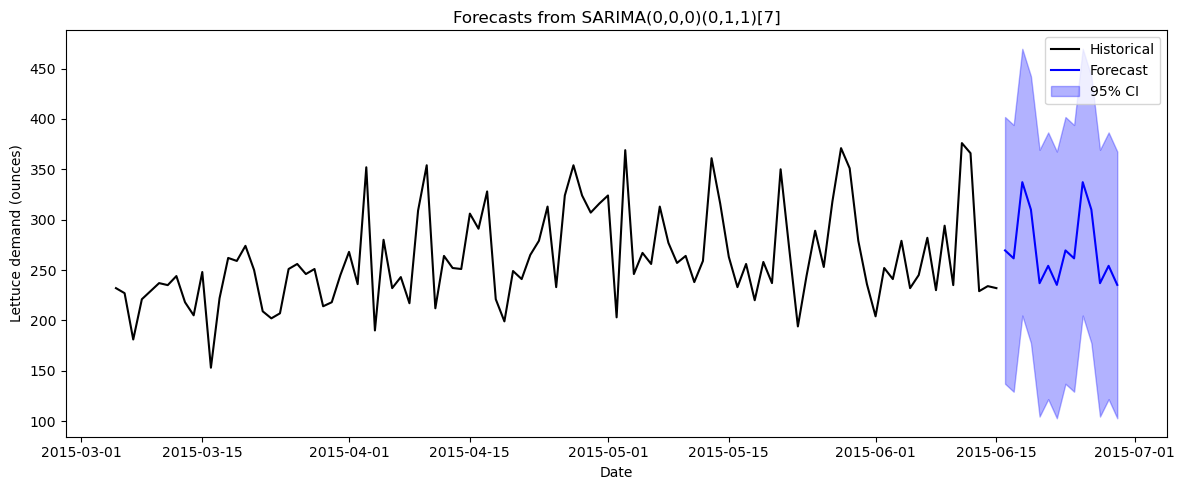

In [265]:
# 1. Plot historical data
plt.figure(figsize=(12, 5))
plt.plot(y_12631, label='Historical', color='black')

# 2. Plot point forecast
plt.plot(forecast_df.index, forecast_df['Point Forecast'], label='Forecast', color='blue')

# 3. Add shaded 80% and 95% intervals
plt.fill_between(forecast_df.index,
                 forecast_df['Low 95'],
                 forecast_df['High 95'],
                 color='blue', alpha=0.3, label='95% CI')

# 4. Final touches
plt.title("Forecasts from SARIMA(0,0,0)(0,1,1)[7]")
plt.xlabel("Date")
plt.ylabel("Lettuce demand (ounces)")
plt.legend()
plt.tight_layout()
plt.show()

## 4 Final Model Selection and Forecast Extraction

In [272]:
all_metrics

[   index        MAE       RMSE       MAPE      SMAPE  Store         Model
 0  Train  18.400973  23.062804  14.125617  13.669424  44673  Holt-Winters
 1   Test  28.209198  38.360589  18.268750  19.682746  44673  Holt-Winters,
    index        MAE       RMSE       MAPE      SMAPE Store         Model
 0  Train  32.055256  42.982746  10.927509  10.511854  4904  Holt-Winters
 1   Test  28.711007  39.324535   9.390451   8.911054  4904  Holt-Winters,
    index        MAE       RMSE       MAPE      SMAPE  Store         Model
 0  Train  33.964752  43.126257  13.198680  12.851408  12631  Holt-Winters
 1   Test  50.853837  55.951963  19.845208  18.249611  12631  Holt-Winters,
    index        MAE       RMSE       MAPE      SMAPE  Store         Model
 0  Train  32.975166  40.381991  25.248711  16.635416  20974  Holt-Winters
 1   Test  34.352091  56.489911  13.637170  15.546311  20974  Holt-Winters,
        index        MAE       RMSE       MAPE      SMAPE  Store   Model
 0  AIC Train  20.208126  

In [274]:
import os
import argparse

# --- Combine forecasts into single DataFrame ---
combined_df = pd.DataFrame({
    'Date': y_46673_hw_fc.index,
    'California 1 (ID:46673)': y_46673_hw_fc['Point Forecast'].values,
    'California 2 (ID:4904)': y_4904_sarima_fc['Point Forecast'].values,
    'New York 1 (ID:12631)': y_12631_sarima_fc['Point Forecast'].values,
    'New York 2 (ID:20974)': y_20974_sarima_fc['Point Forecast'].values,
})

# Display preview
print(combined_df.head())

# --- Save results to descriptive filename ---
out_path = "data/processed/forecast_results.csv"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
combined_df.to_csv(out_path, index=False)
print(f"Saved combined forecast with {len(combined_df)} rows to {out_path}")


# --- Script entrypoint (only triggered when run as .py, ignored in Jupyter) ---
if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser(description="Export combined forecasts to CSV.")
    parser.add_argument(
        "--outfile",
        default=out_path,
        help="Path to save the combined forecast CSV"
    )
    args = parser.parse_args()

    os.makedirs(os.path.dirname(args.outfile), exist_ok=True)
    combined_df.to_csv(args.outfile, index=False)
    print(f"Saved combined forecast with {len(combined_df)} rows to {args.outfile}")

        Date  California 1 (ID:46673)  California 2 (ID:4904)  \
0 2015-06-16                   162.18                  359.08   
1 2015-06-17                   175.32                  343.51   
2 2015-06-18                   166.68                  305.83   
3 2015-06-19                   102.87                  220.87   
4 2015-06-20                    78.84                  222.35   

   New York 1 (ID:12631)  New York 2 (ID:20974)  
0                 269.47                 248.24  
1                 261.56                 272.68  
2                 337.23                 311.72  
3                 309.92                 197.39  
4                 236.91                 184.36  
Saved combined forecast with 14 rows to data/processed/forecast_results.csv


usage: ipykernel_launcher.py [-h] [--outfile OUTFILE]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\max-u.MTU-SFC\AppData\Roaming\jupyter\runtime\kernel-9ef9c844-0761-488f-98a0-7027db72103e.json


SystemExit: 2